In [1]:
import cv2
from collections.abc import Iterable
import warnings
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.ndimage as ndimage
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans, DBSCAN
from skimage.filters import gabor_kernel
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from tqdm.contrib import itertools
from photon_canon.contrib.bio import hemoglobin_mus
from photon_canon.contrib.diffusion_theory import (
    create_diffusion_approximation,
    create_integrated_diffusion_approximation,
)
from photon_canon.lut import LUT
import os
import glob
import json

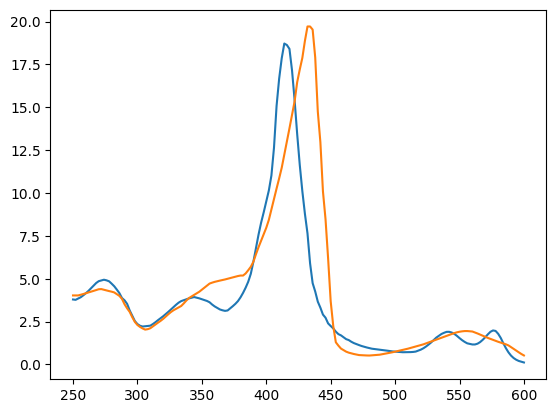

In [2]:
from photon_canon.contrib.bio import eps, wl

w = wl[wl <= 600]
e = eps.T[wl <= 600]
plt.plot(w, e)
plt.show()

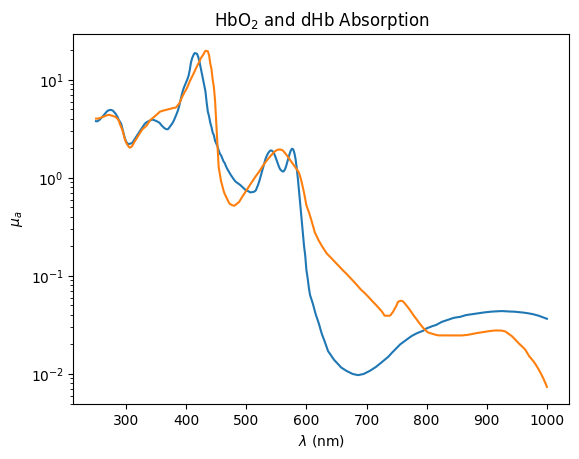

In [3]:
plt.plot(wl, eps.T)
plt.semilogy()
plt.title(r"HbO$_2$ and dHb Absorption")
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"$\mu_a$")
plt.show()

# Building tools

In [4]:
# Helper for dtype conversion
def iterable_array(x):
    x = [x] if not isinstance(x, Iterable) else x
    return np.array(x)

## Model functions
Monte Carlo and Integrated Diffusion Model to fit total concentrations with fixed sO<sub>2</sub>, scattering amplitude, and power.

In [5]:
lut = LUT(dimensions=["mu_s", "mu_a"], extrapolate=True, scale=50000)


def monte_carlo_model_from_hemoglobin(wavelengths, a, b, t, s):
    mu_s, mu_a, _ = hemoglobin_mus(a, b, t, s, wavelengths)
    Rd = lut(mu_s, mu_a, extrapolate=True)
    return Rd


diff_approx = create_integrated_diffusion_approximation(
    (0, np.inf), np.radians(75), 1.33, 0.9
)


def diffusion_model_from_hemoglobin(wavelength, a, b, t, s):
    mu_s, mu_a, _ = hemoglobin_mus(
        a, b, t, s, wavelengths=wavelength, force_feasible=True
    )
    Rd = []
    for mus, mua in zip(mu_s, mu_a):
        Rd.append(diff_approx(mus, mua))
    return np.array(Rd)

### Visual Comparison of models

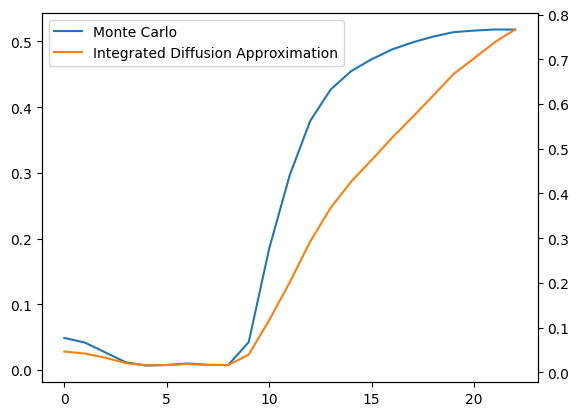

In [6]:
fig = plt.figure()
ax0 = fig.subplots(1, 1)
ax1 = ax0.twinx()
ax0.plot(
    monte_carlo_model_from_hemoglobin(np.arange(500, 730, 10), 10, 1.1, 10, 0.6),
    label="Monte Carlo",
)
ax0.plot([], label="Integrated Diffusion Approximation")
ax1.plot([])
ax1.plot(
    diffusion_model_from_hemoglobin(np.arange(500, 730, 10), 10, 1.1, 10, 0.6),
    label="Integrated Diffusion Approximation",
)
ax0.legend(["Monte Carlo", "Integrated Diffusion Approximation"])
plt.show()

  0%|          | 0/10201 [00:00<?, ?it/s]

C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\diffusion_theory.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  l_prime = 1 / mu_t_prime
C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\diffusion_theory.py:40: RuntimeWarning: invalid value encountered in scalar divide
  a_prime = mu_s_prime / mu_t_prime
C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\diffusion_theory.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  D = 1 / (3 * (mu_s_prime + 0.35 * mu_a))
C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\diffusion_theory.py:86: RuntimeWarning: invalid value encountered in scalar subtract
  rho2 = cylindrical_distance((r, theta, 0), (r_prime, theta_prime, -z_prime - 2 * z_b))
C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\contrib\diffusion_theory.py:89: RuntimeWarning: invalid value encountered in scalar multiply
  Rd = (a_prime * z_prime * (

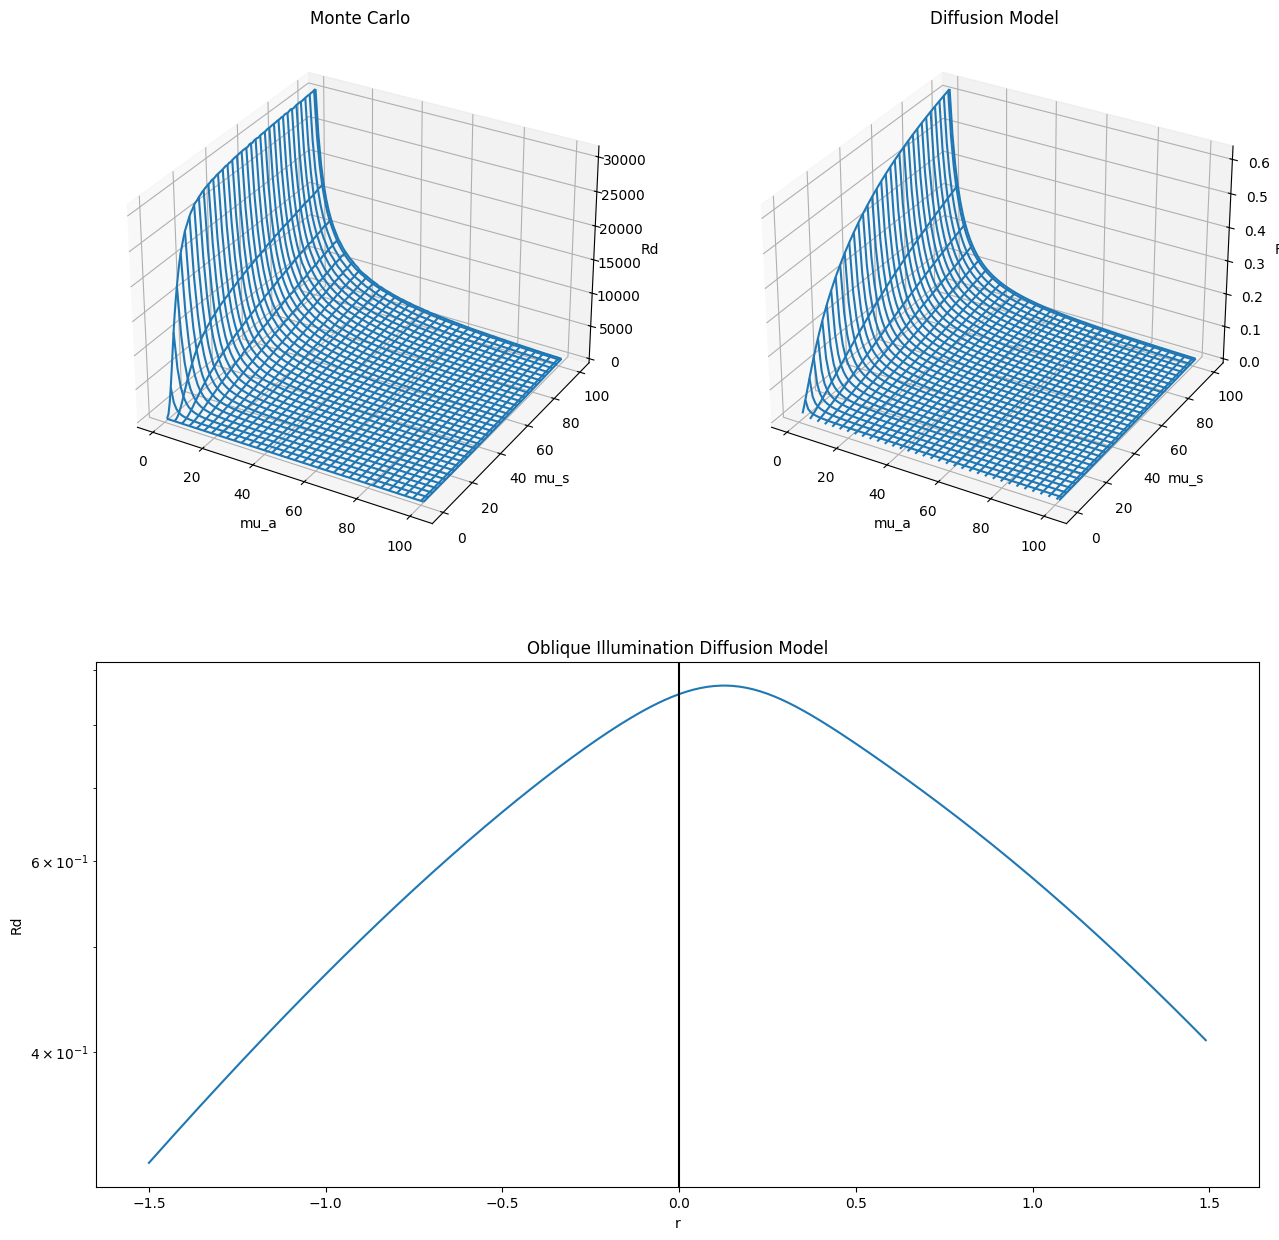

In [7]:
# MC Surface
X, Y, Z = lut.surface()
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(2, 2, 1, projection="3d")
ax.plot_wireframe(Y, X, Z)
ax.set_title("Monte Carlo")
ax.set_xlabel("mu_a")
ax.set_ylabel("mu_s")
ax.set_zlabel("Rd")

# Diffusion model surface
diffusion_model = create_integrated_diffusion_approximation(
    (0, np.inf), np.radians(75), 1.33, 0.9
)
Rd = []
mu_eff = []
for mus, mua in itertools.product(np.unique(X), np.unique(Y)):
    Rd.append(diffusion_model(mus, mua) / diffusion_model(mus, 0))
Rd = np.asarray(Rd).reshape(len(X), len(Y))
ax = fig.add_subplot(2, 2, 2, projection="3d")
ax.plot_wireframe(Y, X, Rd)
ax.set_title("Diffusion Model")
ax.set_xlabel("mu_a")
ax.set_ylabel("mu_s")
ax.set_zlabel("Rd")

# Diffusion model spatial offset
Rd = []
ax = fig.add_subplot(2, 1, 2)
r_range = np.arange(-1.5, 1.5, 0.01)
theta = np.radians(75)
for r in r_range:
    diffusion_model = create_diffusion_approximation(r, theta, 1.33, 0.9)
    Rd.append(diffusion_model(20, 0.25) / diffusion_model(20, 0))
ax.plot(r_range, Rd)
ax.axvline(0, color="k")
ax.semilogy()
ax.set_xlabel("r")
ax.set_ylabel("Rd")
ax.set_title("Oblique Illumination Diffusion Model")

plt.show()

## Preprocessing

In [8]:
def read_imaging_metadata(file_path):
    grouped_metadata = {
        "AbsTime": [],
        "ExpTime": [],
        "Filter": [],
        "AvgInt": [],
        "Wavelength": [],
    }

    # Open and read the file contents
    try:
        with open(file_path, "r") as file:
            json_data = json.load(file)  # Directly load the JSON data from the file

        # Iterate through each entry and group values by field name
        for entry in json_data:
            grouped_metadata["AbsTime"].append(entry.get("AbsTime", None))
            grouped_metadata["ExpTime"].append(entry.get("ExpTime", None))
            grouped_metadata["Filter"].append(entry.get("Filter", None))
            grouped_metadata["AvgInt"].append(entry.get("AvgInt", None))
            grouped_metadata["Wavelength"].append(entry.get("Wavelength", None))

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

    return grouped_metadata

In [9]:
def read_hyperstack(img_dir):
    hs = []
    for img_path in glob.glob(os.path.join(img_dir, "*.tiff")):
        hs.append(cv2.imread(img_path, cv2.IMREAD_UNCHANGED))
    return np.stack(hs, dtype=np.float64)

In [10]:
def normalize_integration_time(hyperstack, integration_time):
    hyperstack /= np.array(integration_time)[:, np.newaxis, np.newaxis]
    return hyperstack

In [11]:
def create_standard_normalization(standard_path, i_i0):
    i0 = []
    for fov_path in os.listdir(standard_path):
        fov = os.path.join(standard_path, fov_path, "cycle1")
        md = read_imaging_metadata(glob.glob(os.path.join(fov, "*.json"))[0])
        hs = read_hyperstack(fov)
        hs = normalize_integration_time(hs, md["ExpTime"])
        i0.append(hs)
    i0 = np.nanmean(i0, axis=0)
    return i0 / i_i0

In [12]:
def normalize_to_standard(hyperstack, standard, bg):
    return (hyperstack - bg) / (standard - bg)

## Fit functions routines

In [13]:
def fit_absorption_from_monte_carlo(wavelengths, reflectance_image, initial_guess):
    # Get the shape of the image (assuming it's a 2D array)
    image_shape = reflectance_image.shape

    # Create empty arrays to store the results for each pixel
    t_image = np.zeros(image_shape[1:])

    # Set bounds for realistic properties
    bounds = ([0], [np.inf])

    # Loop through each pixel in the image
    for i, j in itertools.product(range(image_shape[1]), range(image_shape[2])):
        reflectance = reflectance_image[
            :, i, j
        ]  # Extract reflectance for the pixel across all wavelengths
        if not np.any(np.isnan(reflectance)):
            # Optimize the model parameters for this pixel's reflectance data
            try:
                opt_params, _ = opt.curve_fit(
                    lambda wl, t: monte_carlo_model_from_hemoglobin(
                        wl, 10, 1.1, t, 0.6
                    ),
                    wavelengths,
                    reflectance,
                    p0=initial_guess,
                    maxfev=1000,
                    bounds=bounds,
                )
            except RuntimeError as e:
                warnings.warn(str(e))
                opt_params = [0]
        else:
            opt_params = [0]

        t_image[i, j] = opt_params[0]

    return t_image

In [14]:
# Function to fit model to reflectance data of an image array
def fit_all_from_monte_carlo(wavelengths, reflectance_image, initial_guess):
    # Get the shape of the image (assuming it's a 2D array)
    image_shape = reflectance_image.shape

    # Create empty arrays to store the results for each pixel
    a_image = np.zeros(image_shape[1:])
    b_image = np.zeros(image_shape[1:])
    s_image = np.zeros(image_shape[1:])
    t_image = np.zeros(image_shape[1:])

    # Set bounds for realistic properties
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, 1])

    # Loop through each pixel in the image
    for i, j in itertools.product(range(image_shape[1]), range(image_shape[2])):
        reflectance = reflectance_image[
            :, i, j
        ]  # Extract reflectance for the pixel across all wavelengths
        if not np.any(np.isnan(reflectance)):
            # Optimize the model parameters for this pixel's reflectance data
            try:
                opt_params, _ = opt.curve_fit(
                    lambda wl, a, b, t, s: monte_carlo_model_from_hemoglobin(
                        wl, a, b, t, s
                    ),
                    wavelengths,
                    reflectance,
                    p0=initial_guess,
                    maxfev=1000,
                    bounds=bounds,
                )
            except RuntimeError as e:
                warnings.warn(str(e))
                opt_params = [0] * 4
        else:
            opt_params = [0] * 4

        a_image[i, j] = opt_params[0]
        b_image[i, j] = opt_params[1]
        t_image[i, j] = opt_params[2]
        s_image[i, j] = opt_params[3]

    return a_image, b_image, t_image, s_image

In [15]:
# Function to fit model to absorption data of an image array
def fit_absorption_from_diffusion(wavelengths, reflectance_image, initial_guess):
    # Get the shape of the image (assuming it's a 2D array)
    image_shape = reflectance_image.shape

    # Create empty arrays to store the results for each pixel
    t_image = np.zeros(image_shape[1:])

    # Set bounds for realistic properties
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, 1])

    # Loop through each pixel in the image
    for i, j in itertools.product(range(image_shape[1]), range(image_shape[2])):
        reflectance = reflectance_image[
            :, i, j
        ]  # Extract reflectance for the pixel across all wavelengths
        if not np.any(np.isnan(reflectance)):
            # Optimize the model parameters for this pixel's reflectance data
            try:
                opt_params, _ = opt.curve_fit(
                    lambda wl, t: diffusion_model_from_hemoglobin(wl, 10, 1.1, t, 0.6),
                    wavelengths,
                    reflectance,
                    p0=initial_guess,
                    maxfev=1000,
                    bounds=bounds,
                )
            except RuntimeError as e:
                warnings.warn(str(e))
                opt_params = [0]
        else:
            opt_params = [0]

        t_image[i, j] = opt_params[0]

    return t_image

In [16]:
# Function to fit model to reflectance data of an image array
def fit_all_from_diffusion(wavelengths, reflectance_image, initial_guess):
    # Get the shape of the image (assuming it's a 2D array)
    image_shape = reflectance_image.shape

    # Create empty arrays to store the results for each pixel
    a_image = np.zeros(image_shape[1:])
    b_image = np.zeros(image_shape[1:])
    s_image = np.zeros(image_shape[1:])
    t_image = np.zeros(image_shape[1:])

    # Set bounds for realistic properties
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, 1])

    # Loop through each pixel in the image
    for i, j in itertools.product(range(image_shape[1]), range(image_shape[2])):
        reflectance = reflectance_image[
            :, i, j
        ]  # Extract reflectance for the pixel across all wavelengths
        if not np.any(np.isnan(reflectance)):
            # Optimize the model parameters for this pixel's reflectance data
            try:
                opt_params, _ = opt.curve_fit(
                    lambda wl, a, b, t, s: diffusion_model_from_hemoglobin(
                        wl, a, b, t, s
                    ),
                    wavelengths,
                    reflectance,
                    p0=initial_guess,
                    maxfev=1000,
                    bounds=bounds,
                )
            except RuntimeError as e:
                warnings.warn(str(e))
                opt_params = [0] * 4
        else:
            opt_params = [0] * 4

        a_image[i, j] = opt_params[0]
        b_image[i, j] = opt_params[1]
        t_image[i, j] = opt_params[2]
        s_image[i, j] = opt_params[3]

    return a_image, b_image, t_image, s_image

### Fit scoring functions

In [17]:
def get_local_stdev(image, shape):
    C, H, W = image.shape
    factor = np.asarray((H, W)) // shape
    new_shape = (C, shape[0], factor[0], shape[1], factor[1])
    new_strides = (
        image.strides[0],
        image.strides[1] * factor[0],
        image.strides[1],
        image.strides[2] * factor[1],
        image.strides[2],
    )

    blocks = as_strided(image, shape=new_shape, strides=new_strides)
    return np.nanstd(blocks, axis=(2, 4))

In [18]:
def reduced_chi_squared_for_all(observed, expected, stdev_map):
    return (1 / (np.shape(observed)[0] - 4)) * np.nansum(
        ((observed - expected) / stdev_map) ** 2, axis=0
    )

## Image Middleware

In [19]:
def upsample_map(mini_map, shape):
    return cv2.resize(mini_map, shape, interpolation=cv2.INTER_CUBIC)

In [20]:
def spatial_bin(cube, bin_factor):
    bands, h, w = cube.shape
    h_binned = h // bin_factor
    w_binned = w // bin_factor

    # Crop to make divisible
    cube_cropped = cube[:, : h_binned * bin_factor, : w_binned * bin_factor]

    # Reshape and bin
    cube_reshaped = cube_cropped.reshape(
        bands, h_binned, bin_factor, w_binned, bin_factor
    )

    # Average over binning axes
    cube_binned = cube_reshaped.mean(axis=(2, 4))

    return cube_binned

### Filtering

In [21]:
# Helper function to handle reshaping input images
def prepare_src(src, include_location=False):
    if src.ndim <= 2:
        shape = src.shape
        X = src.reshape(-1, 1)
    elif src.ndim == 3:
        shape = src.shape[1:]
        X = src.reshape(src.shape[0], -1).T
    if include_location:
        x, y = np.meshgrid(
            np.linspace(-0.5, 0.5, shape[0]) * shape[0],
            np.linspace(-0.5, 0.5, shape[1]) * shape[1],
        )
        X = np.column_stack([x.ravel(), y.ravel(), X])
    return X

#### Matched filters

In [22]:
def rotated_kernel_bank(k_size, sigma=1.5, theta_step=np.radians(15)):
    theta = np.arange(0, np.pi, theta_step)

    # Create coordinate system
    m = int(np.max((np.ceil(3 * sigma), np.ceil((k_size - 1) / 2))))
    x, y = np.meshgrid(np.arange(-m, m + 1), np.arange(-m, m + 1))
    p = np.vstack([x.ravel(), y.ravel()])

    # Create rotated coordinates
    rotation_matrix = np.stack(
        [
            np.column_stack([np.cos(theta), -np.sin(theta)]),
            np.column_stack([np.sin(theta), np.cos(theta)]),
        ],
        axis=1,
    )
    r = np.einsum("aij,jk->aik", rotation_matrix, p)
    u = r[:, 0]
    v = r[:, 1]

    # Define the kernel domain
    N = (np.abs(u) <= 3 * sigma) & (np.abs(v) <= k_size / 2)

    # Define kernels
    K = -np.exp(-(u**2) / (2 * sigma**2))

    # Subtract the mean for background zeroing
    K -= np.mean(K, axis=1, keepdims=True)
    K[~N] = 0  # Set outside values to 0

    return K.reshape(len(theta), 2 * m + 1, 2 * m + 1)

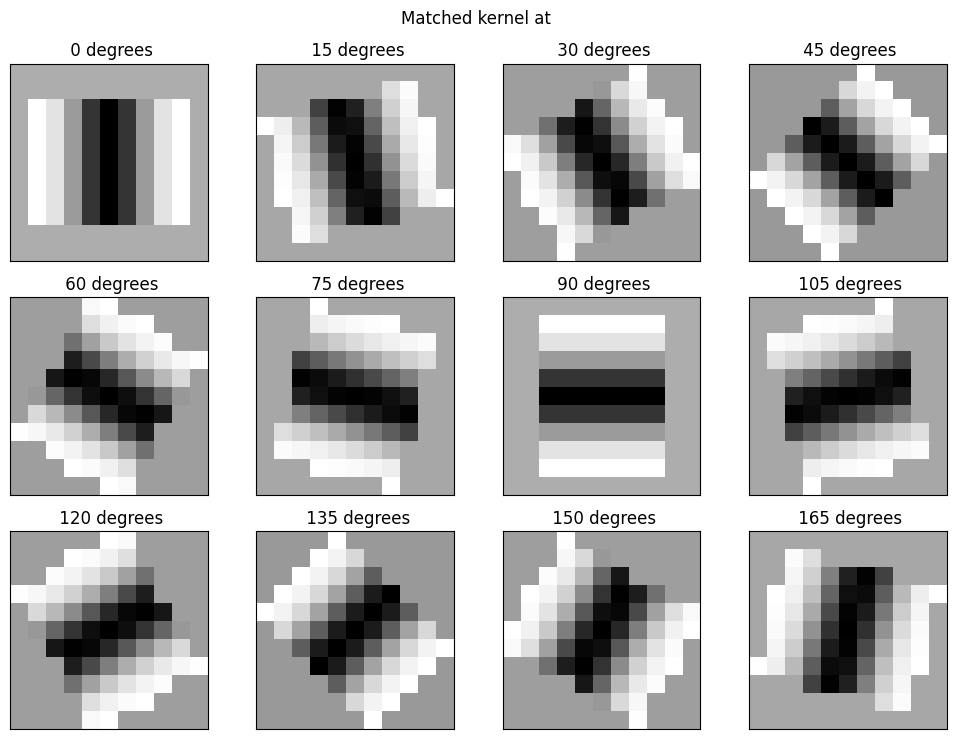

In [23]:
k_size = 7
sigma = 1.5
theta_step = np.radians(15)
K = rotated_kernel_bank(k_size, sigma, theta_step)

fig = plt.figure(figsize=(10, 7.5))
fig.suptitle("Matched kernel at ")
for i in range(K.shape[0]):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.imshow(K[i], "gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f" {np.degrees(theta_step * i):.0f} degrees")
fig.tight_layout()
plt.show()

#### Gabor Filters

In [24]:
def gabor_filter_bank(
    frequency=1, theta_step=np.radians(15), sigma_x=None, sigma_y=None, offset=None
):
    theta = np.arange(0, np.pi, theta_step)
    freqs = iterable_array(frequency)
    sigma_x = iterable_array(sigma_x) if sigma_x is not None else 1.5 / freqs
    sigma_y = iterable_array(sigma_y) if sigma_y is not None else 0.5 / freqs
    offset = iterable_array(offset) if offset is not None else np.zeros_like(freqs)
    kernels = [
        np.abs(gabor_kernel(frequency=f, theta=t, sigma_x=sx, sigma_y=sy, offset=o))
        for t, (f, sx, sy, o) in itertools.product(
            theta, zip(freqs, sigma_x, sigma_y, offset)
        )
    ]
    return kernels

0it [00:00, ?it/s]

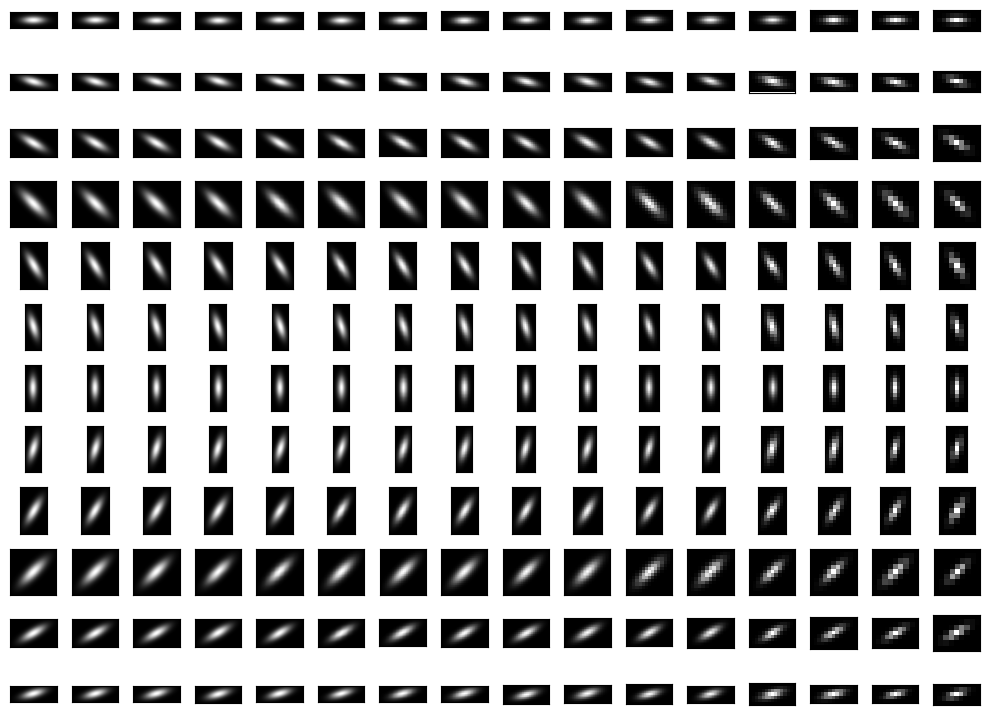

In [46]:
freqs = np.geomspace(0.1, 1, 16)
offset = (0, np.pi / 2)
fig = plt.figure(figsize=(10, 7.5))
kernel_bank = gabor_filter_bank(frequency=freqs)
for i, k in enumerate(kernel_bank):
    ax = fig.add_subplot(int(np.ceil(len(kernel_bank) / len(freqs))), len(freqs), i + 1)
    plt.imshow(kernel_bank[i], "gray")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [26]:
def apply_kernel_bank(src, kernel_bank):
    return np.nanmax(
        [cv2.filter2D(src, -1, k) for (k,) in itertools.product(kernel_bank)], axis=0
    )

#### K-Means Clustering

In [27]:
def k_cluster(src, k=3, include_location=False):
    shape = src.shape[-2:]
    X = prepare_src(src, include_location=include_location)
    if include_location:
        X = StandardScaler().fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto", init="random").fit(X)
    return kmeans.labels_.reshape(shape)

In [28]:
def intra_vs_inter_cluster_variance(src, labels):
    if src.ndim > 2:
        src = src.reshape(src.shape[0], -1).T
        labels = labels.flatten()
    clusters = np.unique(labels)
    centroids = [np.nanmean(src[labels == lab]) for lab in clusters]
    global_mean = np.nanmean(src)
    intra = np.nansum(
        [
            np.nansum((src[labels == lab] - centr) ** 2)
            for lab, centr in zip(clusters, centroids)
        ]
    )
    inter = np.nansum(
        [
            np.count_nonzero(labels == lab) * (centr - global_mean) ** 2
            for lab, centr in zip(clusters, centroids)
        ]
    )
    return inter / (inter + intra)

In [29]:
def try_n_clusters(src, ks):
    # KMeans Clustering
    clusters = np.zeros((len(ks),) + src.shape[-2:])
    scores = np.zeros(len(ks))
    for i, k in enumerate(ks):
        clusters[i] = k_cluster(src, k)
        scores[i] = intra_vs_inter_cluster_variance(src, clusters[i])
    return clusters, scores

In [30]:
def sort_clusters(src, cluster):
    # Get the sort indices for the average intensity of each cluster
    cluster_numbers = np.argsort(
        [np.average(src[..., cluster == i]) for i in np.unique(cluster)]
    )

    # Set the cluster at the index to the index
    sorted_cluster = np.empty_like(cluster)
    for index, n in enumerate(cluster_numbers):
        sorted_cluster[cluster == n] = index
    return sorted_cluster

In [31]:
def find_elbow_clusters(clusters, scores):
    # Find where more clusters stops improving inter/intragroup variance
    elbow = np.argmax(np.gradient(scores)) + 1

    # Select that configuration of  clusters
    return clusters[elbow], elbow


def slice_clusters(src, cluster, slice_to_take=None):
    if slice_to_take is None:
        slice_to_take = slice(2, None)

    # Select the clusters (ordered by intensity and selected from slice)
    cluster = sort_clusters(src, cluster)
    selected = np.unique(cluster)[slice_to_take]

    # Create mask where in the selected cluster
    in_cluster_mask = np.any([cluster == sel for sel in selected], axis=0)
    return in_cluster_mask

#### Feature selectors

In [32]:
def var_selector(src, threshold=None, include_location=False):
    shape = src.shape[-2:]
    X = prepare_src(src, include_location=include_location)
    if threshold is None:
        threshold = np.nanpercentile(
            np.nanvar(X, axis=0), 75
        )  # Default to top 25% of variance
    vt = VarianceThreshold(threshold=threshold)
    X = vt.fit_transform(X)
    feat = vt.get_support()
    return X.reshape(-1, *shape), feat

#### DBSCAN

In [33]:
def db_cluster(src, eps=None, min_samples=None):
    if src.ndim <= 2:
        shape = src.shape
        X = src.reshape(-1, 1)
        if min_samples is None:
            min_samples = 4
    elif src.ndim == 3:
        shape = src.shape[1:]
        X = src.reshape(src.shape[0], -1).T
        if min_samples is None:
            min_samples = src.shape[0]
    x, y = np.meshgrid(
        np.linspace(-0.5, 0.5, shape[0]) * shape[0],
        np.linspace(-0.5, 0.5, shape[1]) * shape[1],
    )
    X = np.column_stack([x.ravel(), y.ravel(), X])
    X = StandardScaler().fit_transform(X)
    if eps is None:
        neigh = NearestNeighbors(n_neighbors=min_samples).fit(X)
        distances, indices = neigh.kneighbors(X)
        k_distance = np.sort(distances[:, min_samples - 1])
        eps = np.sqrt(k_distance[np.argmax(np.gradient(np.gradient(k_distance)))] / 2)
        if eps == 0:
            return np.zeros(shape)
    dbscan = DBSCAN(eps=np.sqrt(eps), min_samples=min_samples).fit(X)
    return dbscan.labels_.reshape(shape)

#### Otsu's method

In [34]:
def otsu_stack(src):
    otsu = np.zeros_like(src)
    if src.ndim > 2:
        for i in range(src.shape[0]):
            _, otsu[i] = cv2.threshold(
                (255 * src[i] / src[i].max()).astype(np.uint8), 0, 255, cv2.THRESH_OTSU
            )
    else:
        _, otsu = cv2.threshold(
            (255 * src / src.max()).astype(np.uint8), 0, 255, cv2.THRESH_OTSU
        )
    return otsu

## Prepare references
### Reflectance standard

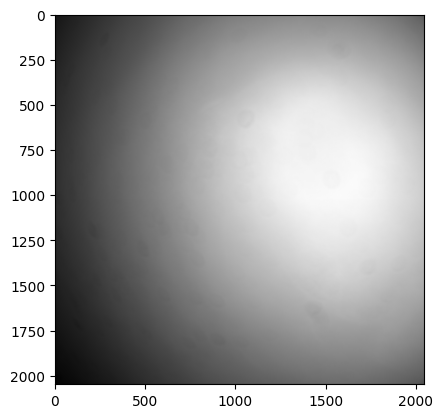

In [35]:
standard_path = r"E:\new df\03312025\ref_stdrd_080"
standard = create_standard_normalization(standard_path, 0.8)
plt.imshow(np.nanmean(standard, axis=0), cmap="gray")
plt.show()

### Background

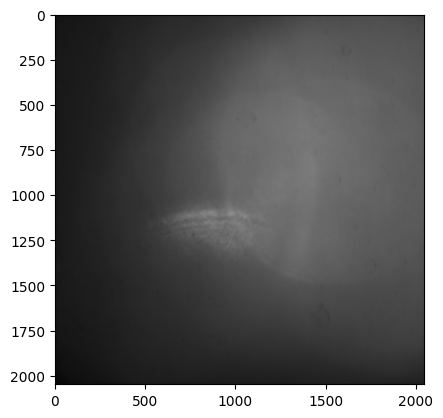

In [36]:
bg_dir = r"E:\new df\03312025\phantoms\window_phantoms\dark\cycle1"
metadata = read_imaging_metadata(glob.glob(os.path.join(bg_dir, "*.json"))[0])
bg = read_hyperstack(bg_dir)
bg = normalize_integration_time(bg, metadata["ExpTime"])
plt.imshow(np.nanmean(bg, axis=0), cmap="gray")
plt.show()

### Known scattering ground truth

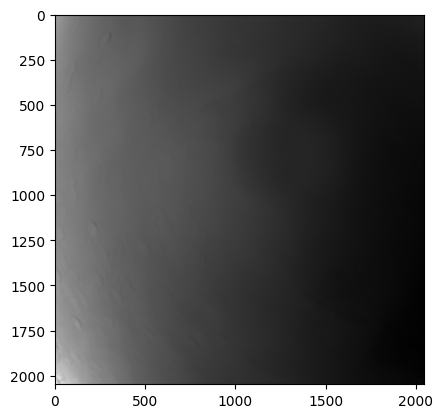

In [37]:
beads_dir = r"E:\new df\03312025\phantoms\window_phantoms\polystyrene\cycle1"
metadata = read_imaging_metadata(glob.glob(os.path.join(beads_dir, "*.json"))[0])
R_imaged = read_hyperstack(beads_dir)
R_imaged = normalize_integration_time(R_imaged, metadata["ExpTime"])
R_imaged = normalize_to_standard(R_imaged, standard, bg)
plt.imshow(np.nanmean(R_imaged, axis=0), cmap="gray")
plt.show()

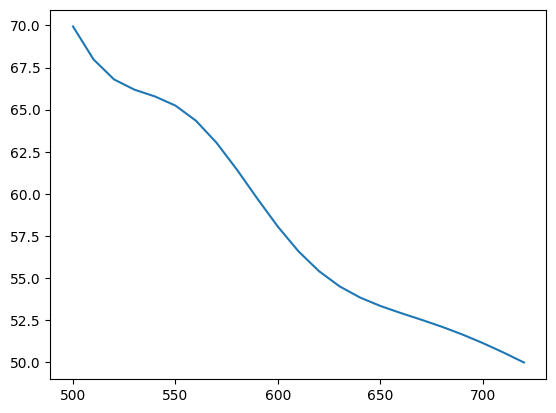

In [38]:
# From in house scatter function
known_scatter = np.array(
    [
        6.9935,
        6.7981,
        6.6795,
        6.6184,
        6.5783,
        6.524,
        6.434,
        6.3038,
        6.1436,
        5.9711,
        5.805,
        5.6596,
        5.5419,
        5.4521,
        5.3856,
        5.3351,
        5.2931,
        5.2535,
        5.2119,
        5.1659,
        5.1149,
        5.0592,
        5,
    ]
)
known_scatter /= 1 - 0.9
plt.plot(metadata["Wavelength"], known_scatter, label="known scatter")
plt.show()

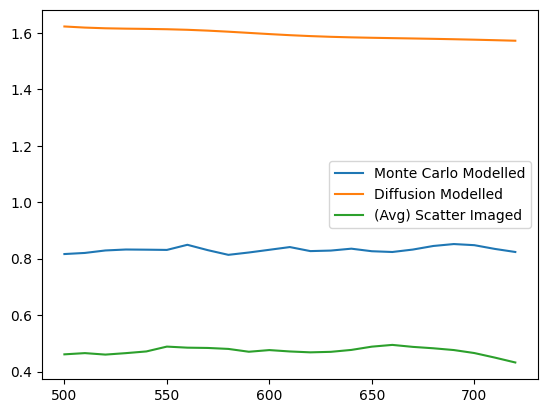

In [39]:
# Display the model
R_monte_carlo = np.array([lut(mus, 0) for mus in known_scatter]).squeeze()
R_diffusion = np.array([diff_approx(mus, 0.1) for mus in known_scatter]).squeeze()
plt.plot(metadata["Wavelength"], R_monte_carlo, label="Monte Carlo Modelled")
plt.plot(metadata["Wavelength"], R_diffusion, label="Diffusion Modelled")
plt.plot(
    metadata["Wavelength"],
    np.nanmean(R_imaged, axis=(1, 2)),
    label="(Avg) Scatter Imaged",
)
plt.legend()
plt.show()

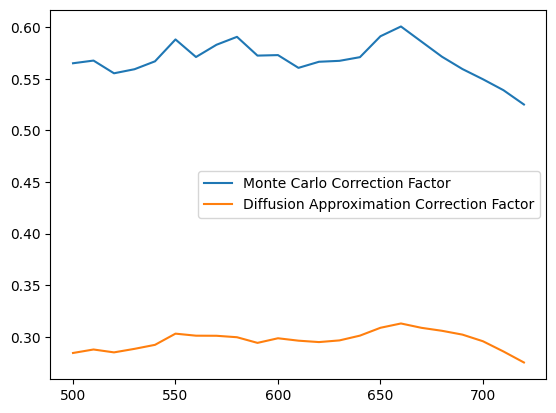

In [40]:
mc_correction = R_imaged / R_monte_carlo[..., np.newaxis, np.newaxis]
da_correction = R_imaged / R_diffusion[..., np.newaxis, np.newaxis]
plt.plot(
    metadata["Wavelength"],
    np.nanmean(mc_correction, axis=(1, 2)),
    label="Monte Carlo Correction Factor",
)
plt.plot(
    metadata["Wavelength"],
    np.nanmean(da_correction, axis=(1, 2)),
    label="Diffusion Approximation Correction Factor",
)
plt.legend()
plt.show()

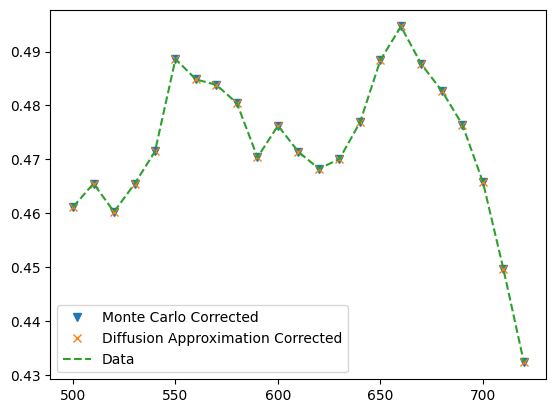

In [41]:
# Display the model
plt.plot(
    metadata["Wavelength"],
    R_monte_carlo * np.nanmean(mc_correction, axis=(1, 2)),
    "v",
    label="Monte Carlo Corrected",
)
plt.plot(
    metadata["Wavelength"],
    R_diffusion * np.nanmean(da_correction, axis=(1, 2)),
    "x",
    label="Diffusion Approximation Corrected",
)
plt.plot(metadata["Wavelength"], np.nanmean(R_imaged, axis=(1, 2)), "--", label="Data")
plt.legend()
plt.show()

## Load and process sample

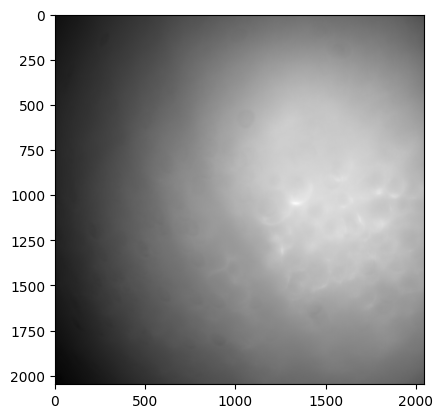

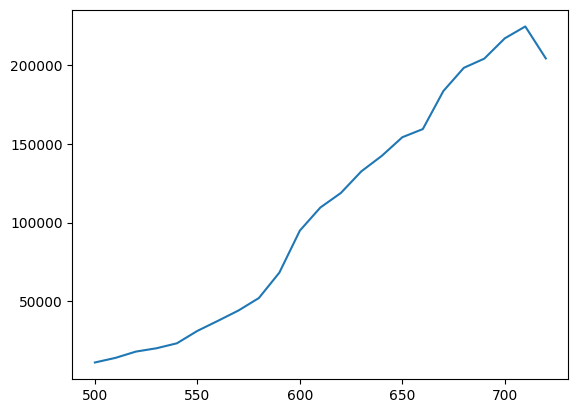

In [79]:
img_dir = r"E:\new df\03312025\1675NT\21\fov2\cycle1"
metadata = read_imaging_metadata(glob.glob(img_dir + os.sep + "*.json")[0])
hs = read_hyperstack(img_dir)
hs = normalize_integration_time(hs, metadata["ExpTime"])
plt.imshow(np.nanmean(hs, axis=0), cmap="gray")
plt.show()
plt.plot(metadata["Wavelength"], np.nanmean(hs, axis=(1, 2)))
plt.show()

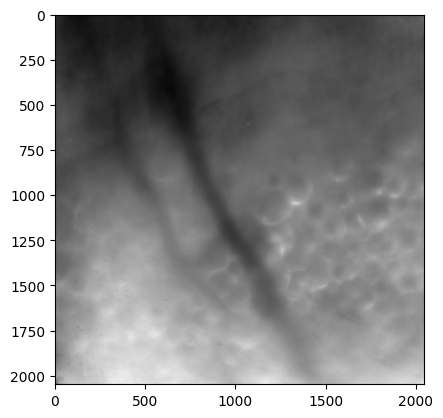

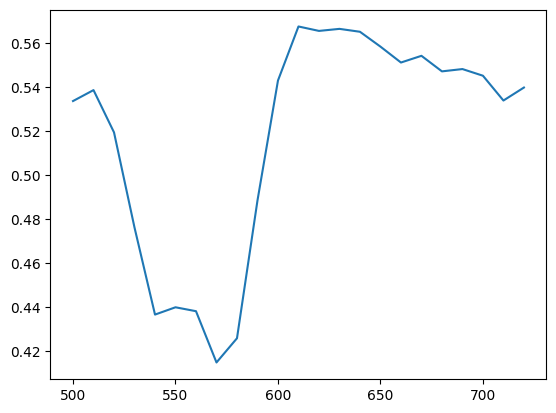

In [80]:
hs = normalize_to_standard(hs, standard, bg)
plt.imshow(np.nanmean(hs, axis=0), cmap="gray")
plt.show()
plt.plot(metadata["Wavelength"], np.nanmean(hs, axis=(1, 2)))
plt.show()

## Comparison of pipelines
### Post-fit segmentation
1) Fit down-sampled image
2) Up-sample to match MPM resolution
3) Apply filters to fit maps to select areas of interest
4) Fit selected areas in full-res image

In [81]:
# Example wavelengths and reflectance data (replace with your data)
reflectance = hs
wavelengths = np.array(metadata["Filter"])
reflectance = spatial_bin(reflectance, 2048 // 64)

# Initial guesses for the tissue properties
initial_guess = [1, 1, 1, 0.5]

# Fit the model
a, b, t, s = fit_all_from_monte_carlo(wavelengths, reflectance, initial_guess)

  0%|          | 0/4096 [00:00<?, ?it/s]

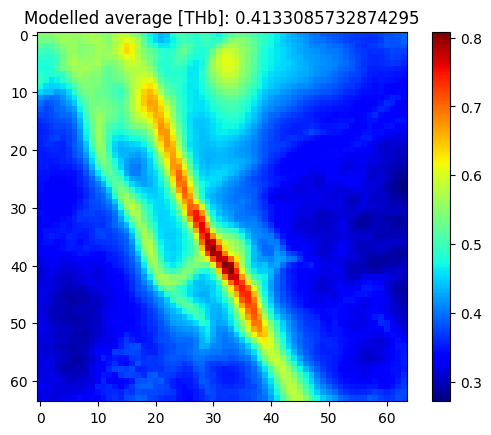

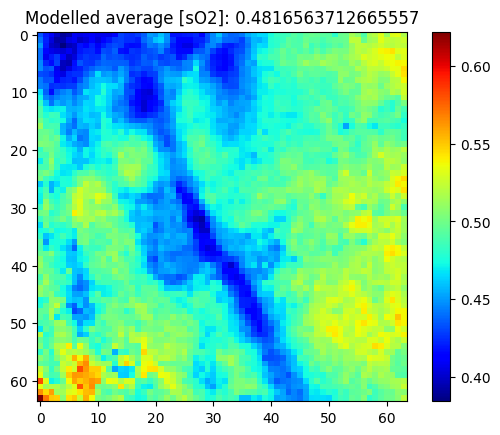

In [82]:
plt.set_cmap("jet")
# Display the image
plt.imshow(t)
plt.title(f"Modelled average [THb]: {np.nanmean(t)}")
plt.colorbar()
plt.show()

# Display the image
plt.imshow(s)
plt.title(f"Modelled average [sO2]: {np.nanmean(s)}")
plt.colorbar()
plt.show()

<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_134276\4162370465.py:38: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0, ax.get_ylim()[0] - 0.15 * np.diff(ax.get_ylim()), f'Avg: {np.nanmean(chi2):0.2f}. Percent of acceptable fits $\chi^2<1.5$): {100 * np.count_nonzero(acceptable) / np.count_nonzero(chi2):0.2f}%', fontsize=12)


  0%|          | 0/4096 [00:00<?, ?it/s]

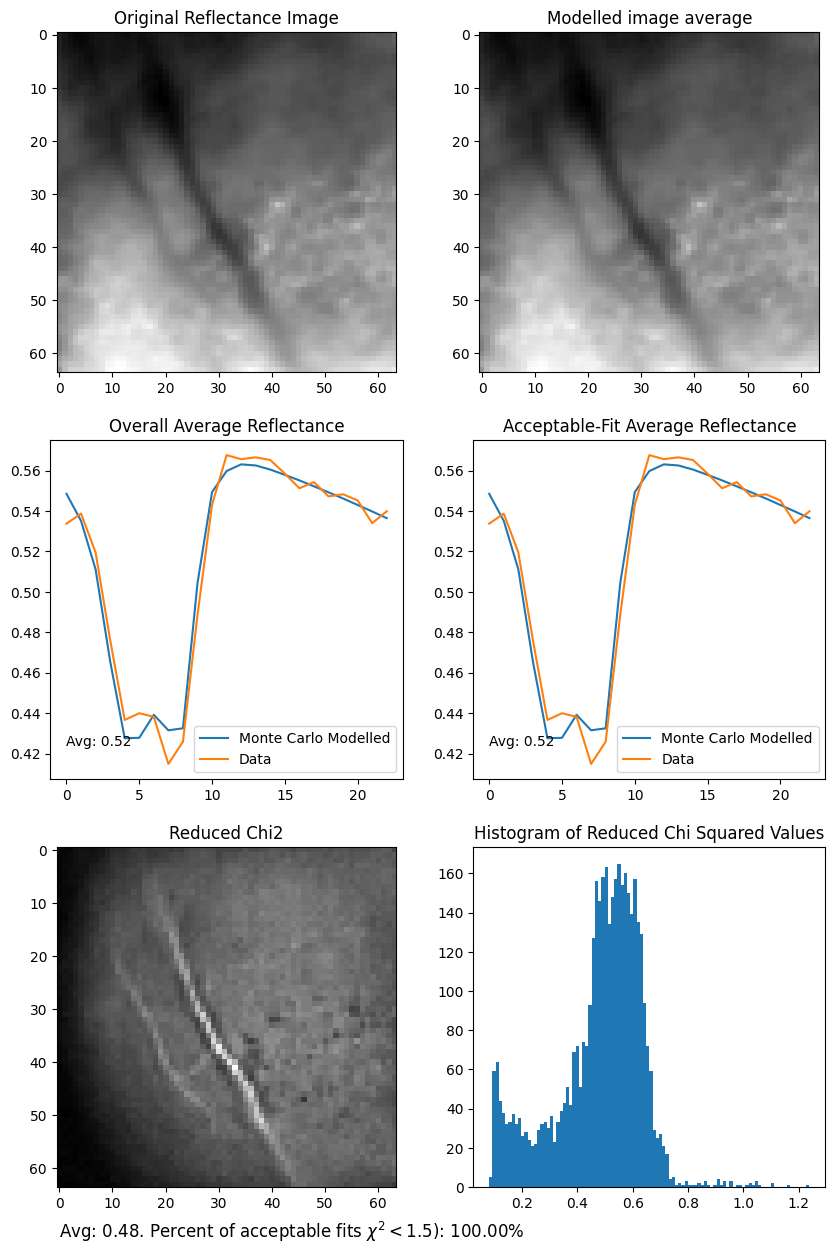

In [84]:
# Evaluate the model
modelled = np.zeros_like(reflectance)
for i, j in itertools.product(range(reflectance.shape[1]), range(reflectance.shape[2])):
    modelled[:, i, j] = monte_carlo_model_from_hemoglobin(
        wavelengths, a[i, j], b[i, j], t[i, j], s[i, j]
    )
sigma = get_local_stdev(hs, (64, 64))
chi2 = reduced_chi_squared_for_all(reflectance, modelled, sigma)
acceptable = chi2 < 1.5

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(np.average(reflectance, axis=0), cmap="gray")
ax.set_title("Original Reflectance Image")

# Display the model reconstruction
ax = fig.add_subplot(3, 2, 2)
ax.imshow(np.average(modelled, axis=0), "gray")
ax.set_title("Modelled image average")

# Display the fit
ax = fig.add_subplot(3, 2, 3)
ax.plot(np.nanmean(modelled, axis=(1, 2)), label="Monte Carlo Modelled")
ax.plot(np.average(reflectance, axis=(1, 2)), label="Data")
ax.set_title("Overall Average Reflectance")
ax.text(
    0,
    ax.get_ylim()[0] + 0.1 * np.diff(ax.get_ylim()),
    f"Avg: {np.nanmean(modelled):0.2f}",
)
ax.legend()

ax = fig.add_subplot(3, 2, 4)
ax.plot(np.average(modelled[:, acceptable], axis=(1,)), label="Monte Carlo Modelled")
ax.plot(np.average(reflectance[:, acceptable], axis=(1,)), label="Data")
ax.set_title("Acceptable-Fit Average Reflectance")
ax.text(
    0,
    ax.get_ylim()[0] + 0.1 * np.diff(ax.get_ylim()),
    f"Avg: {np.nanmean(modelled[:, acceptable]):0.2f}",
)
ax.legend()

# Display fit map
ax = fig.add_subplot(3, 2, 5)
ax.imshow(chi2, "gray")
ax.set_title("Reduced Chi2")
ax.text(
    0,
    ax.get_ylim()[0] - 0.15 * np.diff(ax.get_ylim()),
    f"Avg: {np.nanmean(chi2):0.2f}. Percent of acceptable fits $\chi^2<1.5$): {100 * np.count_nonzero(acceptable) / np.count_nonzero(chi2):0.2f}%",
    fontsize=12,
)

ax = fig.add_subplot(3, 2, 6)
ax.hist(chi2.flatten(), bins=100)
ax.set_title("Histogram of Reduced Chi Squared Values")

plt.show()

In [85]:
np.nanmean(s[acceptable])

np.float64(0.4816563712665557)

#### Segmentation techniques

C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_c

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

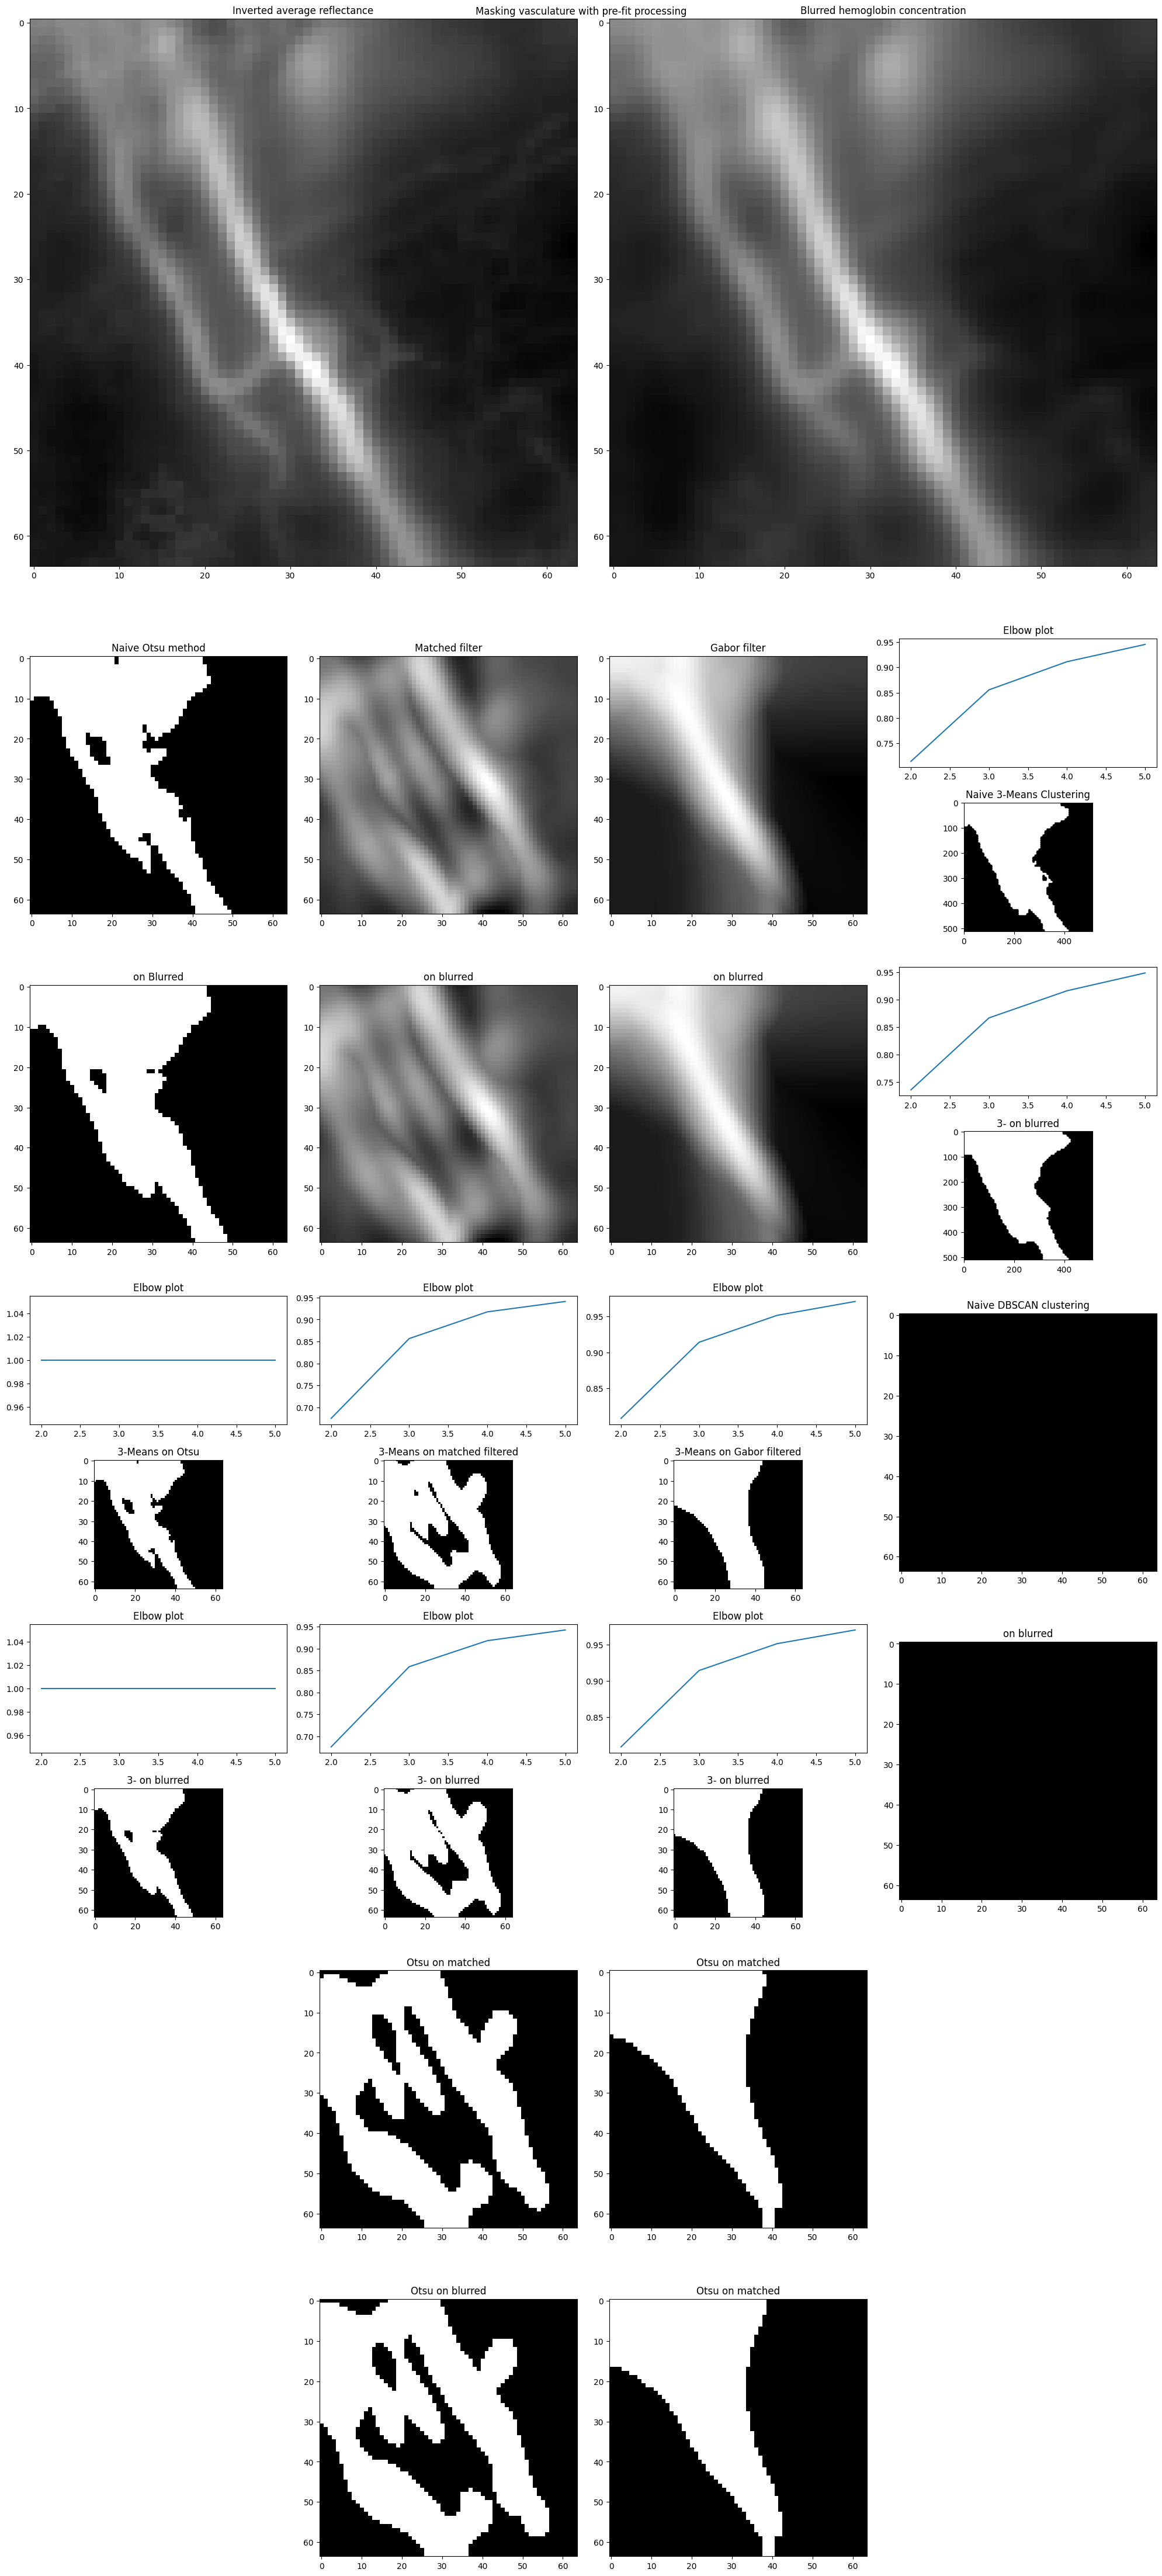

In [86]:
fig = plt.figure(figsize=(20, 45))
gs = gridspec.GridSpec(nrows=16, ncols=4, figure=fig)
fig.suptitle("Masking vasculature with pre-fit processing")
ref = t

# Reusable params
frequency = np.geomspace(0.01 / 8, 1 / 8, 16)
ks = np.arange(2, 6, 1)

# Original
ax = fig.add_subplot(gs[0:4, 0:2])
ax.imshow(ref, "gray")
ax.set_title("Inverted average reflectance")

ax = fig.add_subplot(gs[0:4, 2:4])
blurred = cv2.blur(ref, (3, 3))
ax.imshow(blurred, "gray")
ax.set_title("Blurred hemoglobin concentration")

# Otsu's Method
ax = fig.add_subplot(gs[4:6, 0])
otsu = otsu_stack(ref)
ax.imshow(otsu, "gray")
ax.set_title("Naive Otsu method")

# K-Clustered Otsu
clusters, scores = try_n_clusters(otsu, ks)
ax = fig.add_subplot(gs[8, 0])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[9, 0])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(otsu, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}-Means on Otsu")

# Blurred Otsu
ax = fig.add_subplot(gs[6:8, 0])
otsu = otsu_stack(blurred)
ax.imshow(otsu, "gray")
ax.set_title("on Blurred")

# K-Clustered blurred Otsu
clusters, scores = try_n_clusters(otsu, ks)
ax = fig.add_subplot(gs[10, 0])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[11, 0])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(otsu, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# -- MATCHED -- #
# Matched filter
kernel_bank = rotated_kernel_bank(15, 5, np.radians(15))
ax = fig.add_subplot(gs[4:6, 1])
matched = apply_kernel_bank(ref, kernel_bank)
ax.imshow(matched, "gray")
ax.set_title("Matched filter")

# K-Cluster matched
clusters, scores = try_n_clusters(matched, ks)
ax = fig.add_subplot(gs[8, 1])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[9, 1])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(matched, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}-Means on matched filtered")

# Otsu's on Matched
otsu = otsu_stack(matched)
ax = fig.add_subplot(gs[12:14, 1])
ax.imshow(otsu, "gray")
ax.set_title("Otsu on matched")

# Blurred matched
ax = fig.add_subplot(gs[6:8, 1])
matched = apply_kernel_bank(blurred, kernel_bank)
ax.imshow(matched, "gray")
ax.set_title("on blurred")

# Clustered blurred matched
clusters, scores = try_n_clusters(matched, ks)
ax = fig.add_subplot(gs[10, 1])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[11, 1])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(matched, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# Otsus on blurred matched
otsu = otsu_stack(matched)
ax = fig.add_subplot(gs[14:16, 1])
ax.imshow(otsu, "gray")
ax.set_title("Otsu on blurred")

# -- GABOR -- #
# Gabor filter
ax = fig.add_subplot(gs[4:6, 2])
kernel_bank = gabor_filter_bank(frequency)
gabored = apply_kernel_bank(ref, kernel_bank)
ax.imshow(gabored, "gray")
ax.set_title("Gabor filter")

# K-Clustered gabor
clusters, scores = try_n_clusters(gabored, ks)
ax = fig.add_subplot(gs[8, 2])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(gabored, clusters[elbow], slice(elbow, None))
ax = fig.add_subplot(gs[9, 2])
ax.imshow(cv2.blur(cluster.astype(np.uint8), (5, 5)), "gray")
ax.set_title(f"{ks[elbow]}-Means on Gabor filtered")

# Otsu on gabor
otsu = otsu_stack(gabored)
ax = fig.add_subplot(gs[12:14, 2])
ax.imshow(otsu, "gray")
ax.set_title("Otsu on matched")

# Blurred gabor
ax = fig.add_subplot(gs[6:8, 2])
gabored = apply_kernel_bank(blurred, kernel_bank)
ax.imshow(gabored, "gray")
ax.set_title("on blurred")

# K-Clustered blurred Gabor
clusters, scores = try_n_clusters(gabored, ks)
ax = fig.add_subplot(gs[10, 2])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(gabored, clusters[elbow], slice(elbow, None))
ax = fig.add_subplot(gs[11, 2])
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# Otsu on blurred gabor
otsu = otsu_stack(gabored)
ax = fig.add_subplot(gs[14:16, 2])
ax.imshow(otsu, "gray")
ax.set_title("Otsu on matched")

# -- CLUSTERERS -- #
# Naive KMeans Clustering
clusters, scores = try_n_clusters(ref, ks)
ax = fig.add_subplot(gs[4, 3])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[5, 3])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(ref, clusters[elbow], slice(elbow, None))
ax.imshow(cv2.resize(cluster.astype(np.uint8), (512, 512)), "gray")
ax.set_title(f"Naive {ks[elbow]}-Means Clustering")

# Naive DBSCAN
src = cv2.resize(ref, (64, 64), interpolation=cv2.INTER_CUBIC)
ax = fig.add_subplot(gs[8:10, 3])
clusters = db_cluster(src)
ax.imshow(clusters, "gray")
ax.set_title("Naive DBSCAN clustering")

# Naive KMeans Blurred
clusters, scores = try_n_clusters(blurred, ks)
ax = fig.add_subplot(gs[6, 3])
ax.plot(ks, scores)
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(blurred, clusters[elbow], slice(elbow, None))
ax = fig.add_subplot(gs[7, 3])
ax.imshow(cv2.resize(cluster.astype(np.uint8), (512, 512)), "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# Naive DB-Clustered on blurred
src = cv2.resize(blurred, (64, 64), interpolation=cv2.INTER_CUBIC)
ax = fig.add_subplot(gs[10:12, 3])
clusters = db_cluster(src)
ax.imshow(clusters, "gray")
ax.set_title("on blurred")

fig.tight_layout()
plt.show()


### Pre-fit segmentation
1) Segment vasculature
2) Mask regions of interest in full-res image
3) Fit only ROI


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

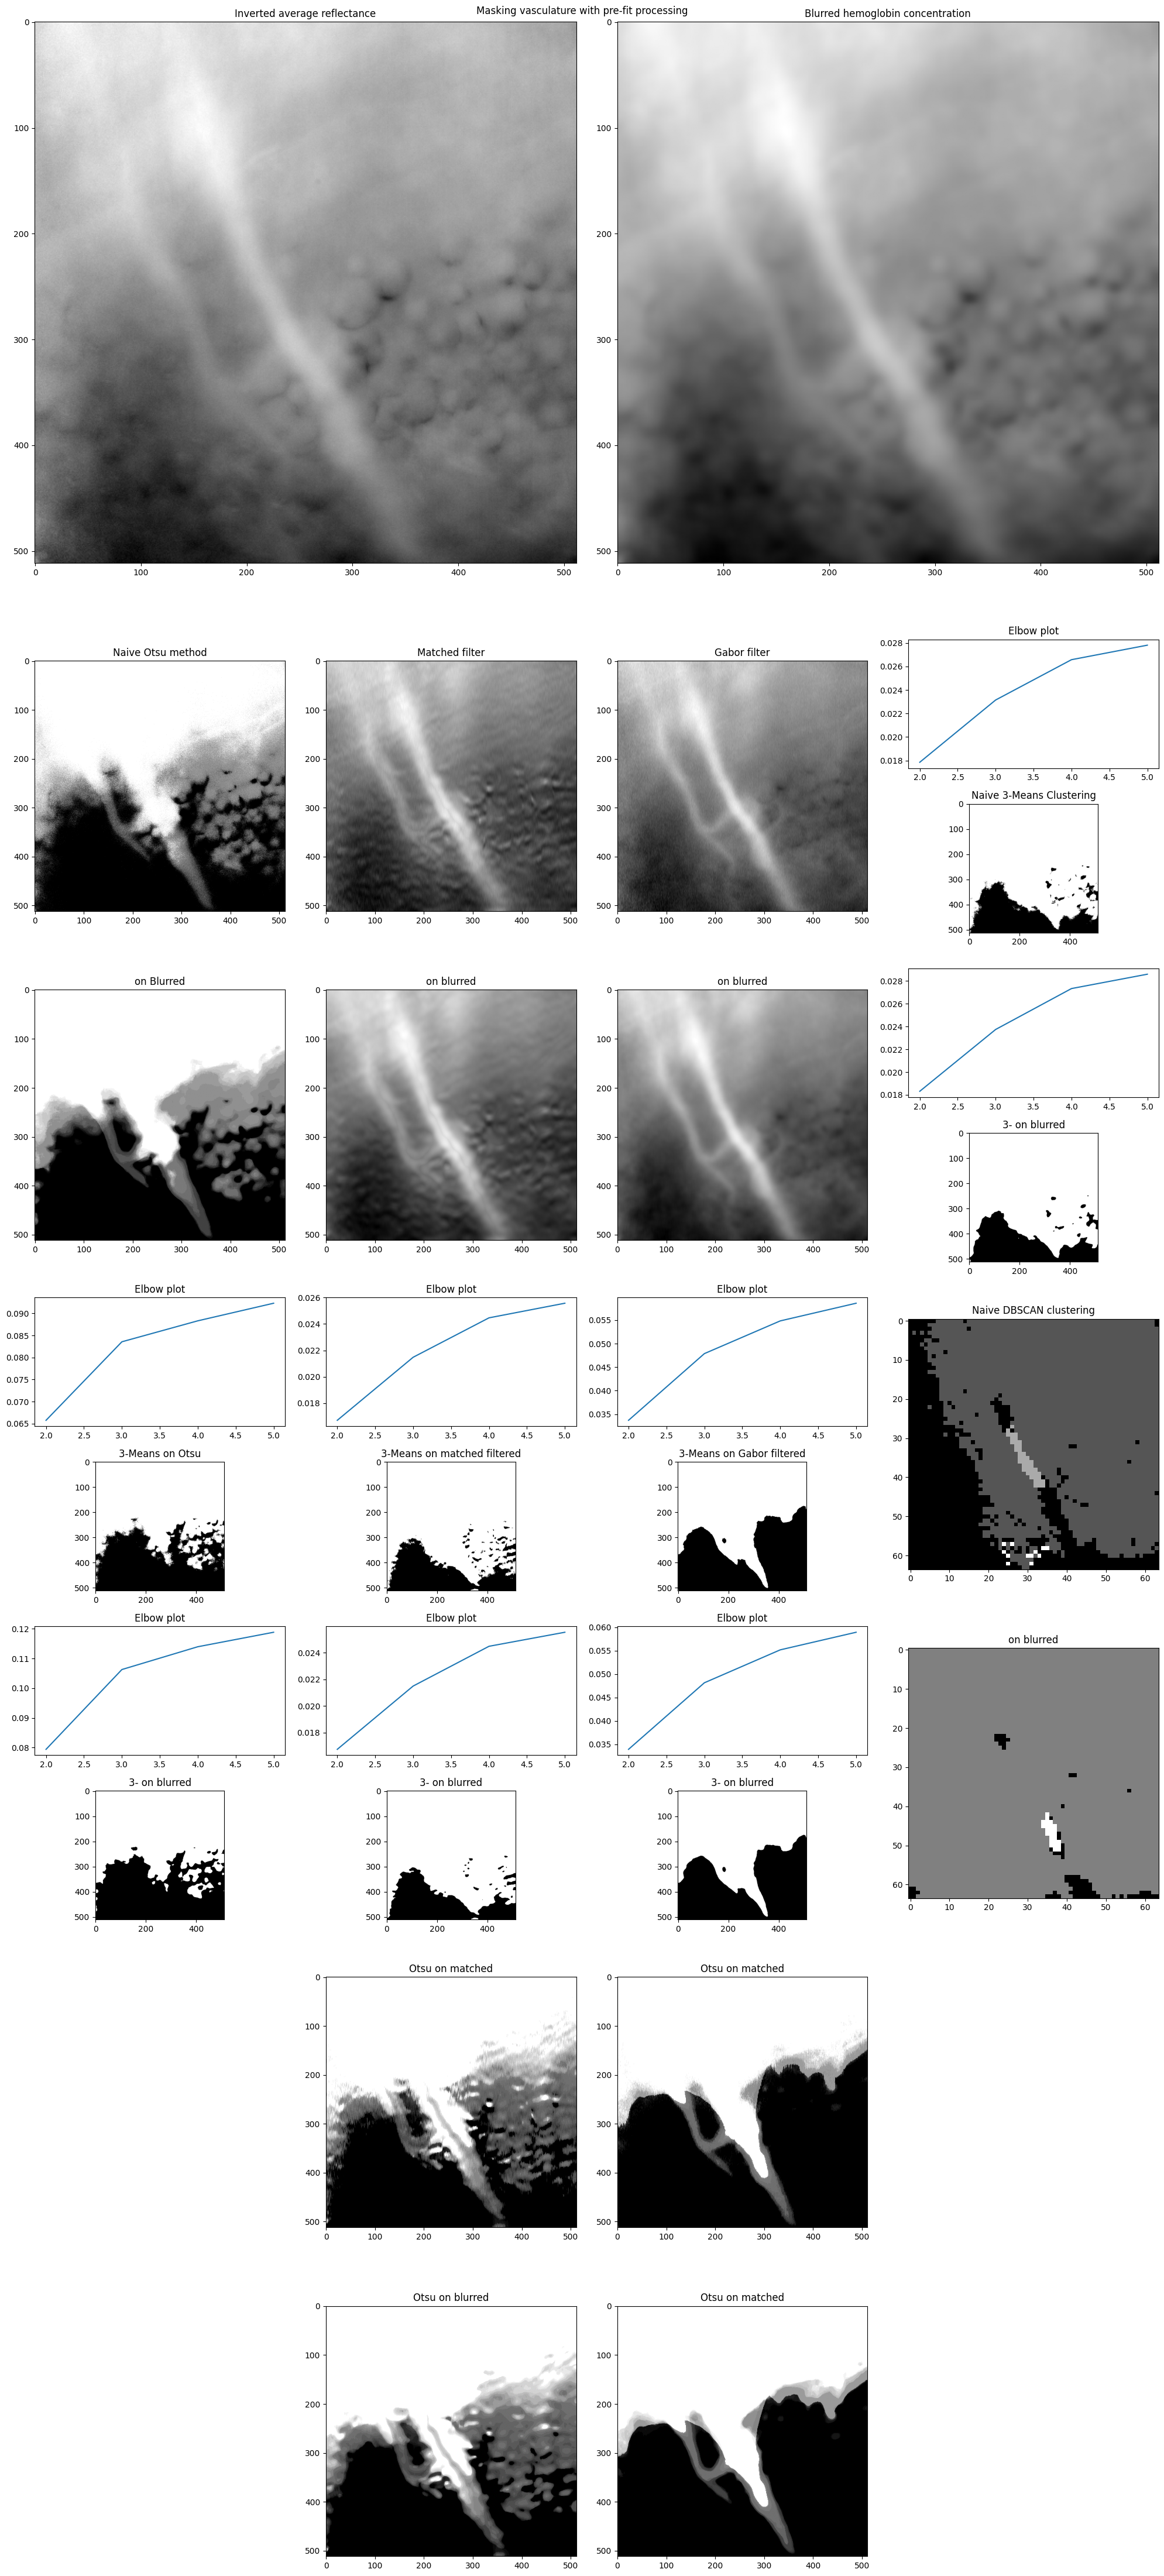

In [87]:
fig = plt.figure(figsize=(20, 45))
gs = gridspec.GridSpec(nrows=16, ncols=4, figure=fig)
fig.suptitle("Masking vasculature with pre-fit processing")
ref = np.array(
    [
        cv2.resize(hs[i], (512, 512), interpolation=cv2.INTER_CUBIC)
        for i in range(hs.shape[0])
    ]
)
ref = ref.max() - ref  # Invert so vasculature is brighter

# Reusable params
frequency = np.geomspace(0.01, 1, 16)
ks = np.arange(2, 6, 1)
levels_to_take = slice(2, None)

# Original
ax = fig.add_subplot(gs[0:4, 0:2])
ax.imshow(np.nanmean(ref, axis=0), "gray")
ax.set_title("Inverted average reflectance")

ax = fig.add_subplot(gs[0:4, 2:4])
blurred = np.array([cv2.blur(ref[i], (9, 9)) for i in range(ref.shape[0])])
ax.imshow(np.nanmean(blurred, axis=0), "gray")
ax.set_title("Blurred hemoglobin concentration")

# Otsu's Method
ax = fig.add_subplot(gs[4:6, 0])
otsu = otsu_stack(ref)
ax.imshow(np.sum(otsu, axis=0), "gray")
ax.set_title("Naive Otsu method")

# K-Clustered Otsu
clusters, scores = try_n_clusters(otsu, ks)
ax = fig.add_subplot(gs[8, 0])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[9, 0])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(otsu, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}-Means on Otsu")

# Blurred Otsu
ax = fig.add_subplot(gs[6:8, 0])
otsu = otsu_stack(blurred)
ax.imshow(np.sum(otsu, axis=0), "gray")
ax.set_title("on Blurred")

# K-Clustered blurred Otsu
clusters, scores = try_n_clusters(otsu, ks)
ax = fig.add_subplot(gs[10, 0])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[11, 0])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(otsu, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# -- MATCHED -- #
# Matched filter
kernel_bank = rotated_kernel_bank(15, 5, np.radians(15))
ax = fig.add_subplot(gs[4:6, 1])
matched = apply_kernel_bank(ref, kernel_bank)
ax.imshow(np.max(matched, axis=0), "gray")
ax.set_title("Matched filter")

# K-Cluster matched
clusters, scores = try_n_clusters(matched, ks)
ax = fig.add_subplot(gs[8, 1])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[9, 1])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(matched, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}-Means on matched filtered")

# Otsu's on Matched
otsu = otsu_stack(matched)
ax = fig.add_subplot(gs[12:14, 1])
ax.imshow(np.sum(otsu, axis=0), "gray")
ax.set_title("Otsu on matched")

# Blurred matched
ax = fig.add_subplot(gs[6:8, 1])
matched = apply_kernel_bank(blurred, kernel_bank)
ax.imshow(np.max(matched, axis=0), "gray")
ax.set_title("on blurred")

# Clustered blurred matched
clusters, scores = try_n_clusters(matched, ks)
ax = fig.add_subplot(gs[10, 1])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[11, 1])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(matched, clusters[elbow], slice(elbow, None))
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# Otsus on blurred matched
otsu = otsu_stack(matched)
ax = fig.add_subplot(gs[14:16, 1])
ax.imshow(np.sum(otsu, axis=0), "gray")
ax.set_title("Otsu on blurred")

# -- GABOR -- #
# Gabor filter
ax = fig.add_subplot(gs[4:6, 2])
kernel_bank = gabor_filter_bank(frequency)
gabored = apply_kernel_bank(ref, kernel_bank)
ax.imshow(np.max(gabored, axis=0), "gray")
ax.set_title("Gabor filter")

# K-Clustered gabor
clusters, scores = try_n_clusters(gabored, ks)
ax = fig.add_subplot(gs[8, 2])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(gabored, clusters[elbow], slice(elbow, None))
ax = fig.add_subplot(gs[9, 2])
ax.imshow(cv2.blur(cluster.astype(np.uint8), (5, 5)), "gray")
ax.set_title(f"{ks[elbow]}-Means on Gabor filtered")

# Otsu on gabor
otsu = otsu_stack(gabored)
ax = fig.add_subplot(gs[12:14, 2])
ax.imshow(np.sum(otsu, axis=0), "gray")
ax.set_title("Otsu on matched")

# Blurred gabor
ax = fig.add_subplot(gs[6:8, 2])
gabored = apply_kernel_bank(blurred, kernel_bank)
ax.imshow(np.max(gabored, axis=0), "gray")
ax.set_title("on blurred")

# K-Clustered blurred Gabor
clusters, scores = try_n_clusters(gabored, ks)
ax = fig.add_subplot(gs[10, 2])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(gabored, clusters[elbow], slice(elbow, None))
ax = fig.add_subplot(gs[11, 2])
ax.imshow(cluster, "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# Otsu on blurred gabor
otsu = otsu_stack(gabored)
ax = fig.add_subplot(gs[14:16, 2])
ax.imshow(np.sum(otsu, axis=0), "gray")
ax.set_title("Otsu on matched")

# -- CLUSTERERS -- #
# Naive KMeans Clustering
clusters, scores = try_n_clusters(ref, ks)
ax = fig.add_subplot(gs[4, 3])
ax.plot(ks, scores)
ax.set_title("Elbow plot")
ax = fig.add_subplot(gs[5, 3])
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(ref, clusters[elbow], slice(elbow, None))
ax.imshow(cv2.resize(cluster.astype(np.uint8), (512, 512)), "gray")
ax.set_title(f"Naive {ks[elbow]}-Means Clustering")

# Naive DBSCAN
src = np.array(
    [
        cv2.resize(ref[i], (64, 64), interpolation=cv2.INTER_CUBIC)
        for i in range(ref.shape[0])
    ]
)
ax = fig.add_subplot(gs[8:10, 3])
clusters = db_cluster(src)
ax.imshow(clusters, "gray")
ax.set_title("Naive DBSCAN clustering")

# Naive KMeans Blurred
clusters, scores = try_n_clusters(blurred, ks)
ax = fig.add_subplot(gs[6, 3])
ax.plot(ks, scores)
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(blurred, clusters[elbow], slice(elbow, None))
ax = fig.add_subplot(gs[7, 3])
ax.imshow(cv2.resize(cluster.astype(np.uint8), (512, 512)), "gray")
ax.set_title(f"{ks[elbow]}- on blurred")

# Naive DB-Clustered on blurred
src = np.array(
    [
        cv2.resize(blurred[i], (64, 64), interpolation=cv2.INTER_CUBIC)
        for i in range(ref.shape[0])
    ]
)
ax = fig.add_subplot(gs[10:12, 3])
clusters = db_cluster(src)
ax.imshow(clusters, "gray")
ax.set_title("on blurred")

fig.tight_layout()
plt.show()

##### Trial Segmentation revision
######

In [88]:
def cluster_flow(src, ks):
    cluster_maps, _ = try_n_clusters(src, ks)
    cluster, elbow = find_elbow_clusters(cluster_maps, scores)
    mask = slice_clusters(src, cluster, slice(1, None))
    return cluster, mask, elbow

In [102]:
freqs = np.geomspace(0.01, 1, 16)
ks = np.arange(1, 6, 1)

# Gabor filtering
kernel_bank = gabor_filter_bank(freqs)
gabored = apply_kernel_bank(ref, kernel_bank)
otsu_gabored = otsu_stack(gabored)
cluster_gabored, _, _ = cluster_flow(gabored, ks)

# Difference of gabor in differential absorption regions
diff_gabored = gabored[:9] - gabored[-9:]
otsu_diff = otsu_stack(diff_gabored)
cluster_diff, _, _ = cluster_flow(diff_gabored, ks)

# Gabor on difference of differential absorption regions
diff = ref[:9] - ref[-9:]
gabored_diff = apply_kernel_bank(diff, kernel_bank)
otsu_gabored_diff = otsu_stack(gabored_diff)
cluster_gabored_diff, _, _ = cluster_flow(gabored_diff, ks)

0it [00:00, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

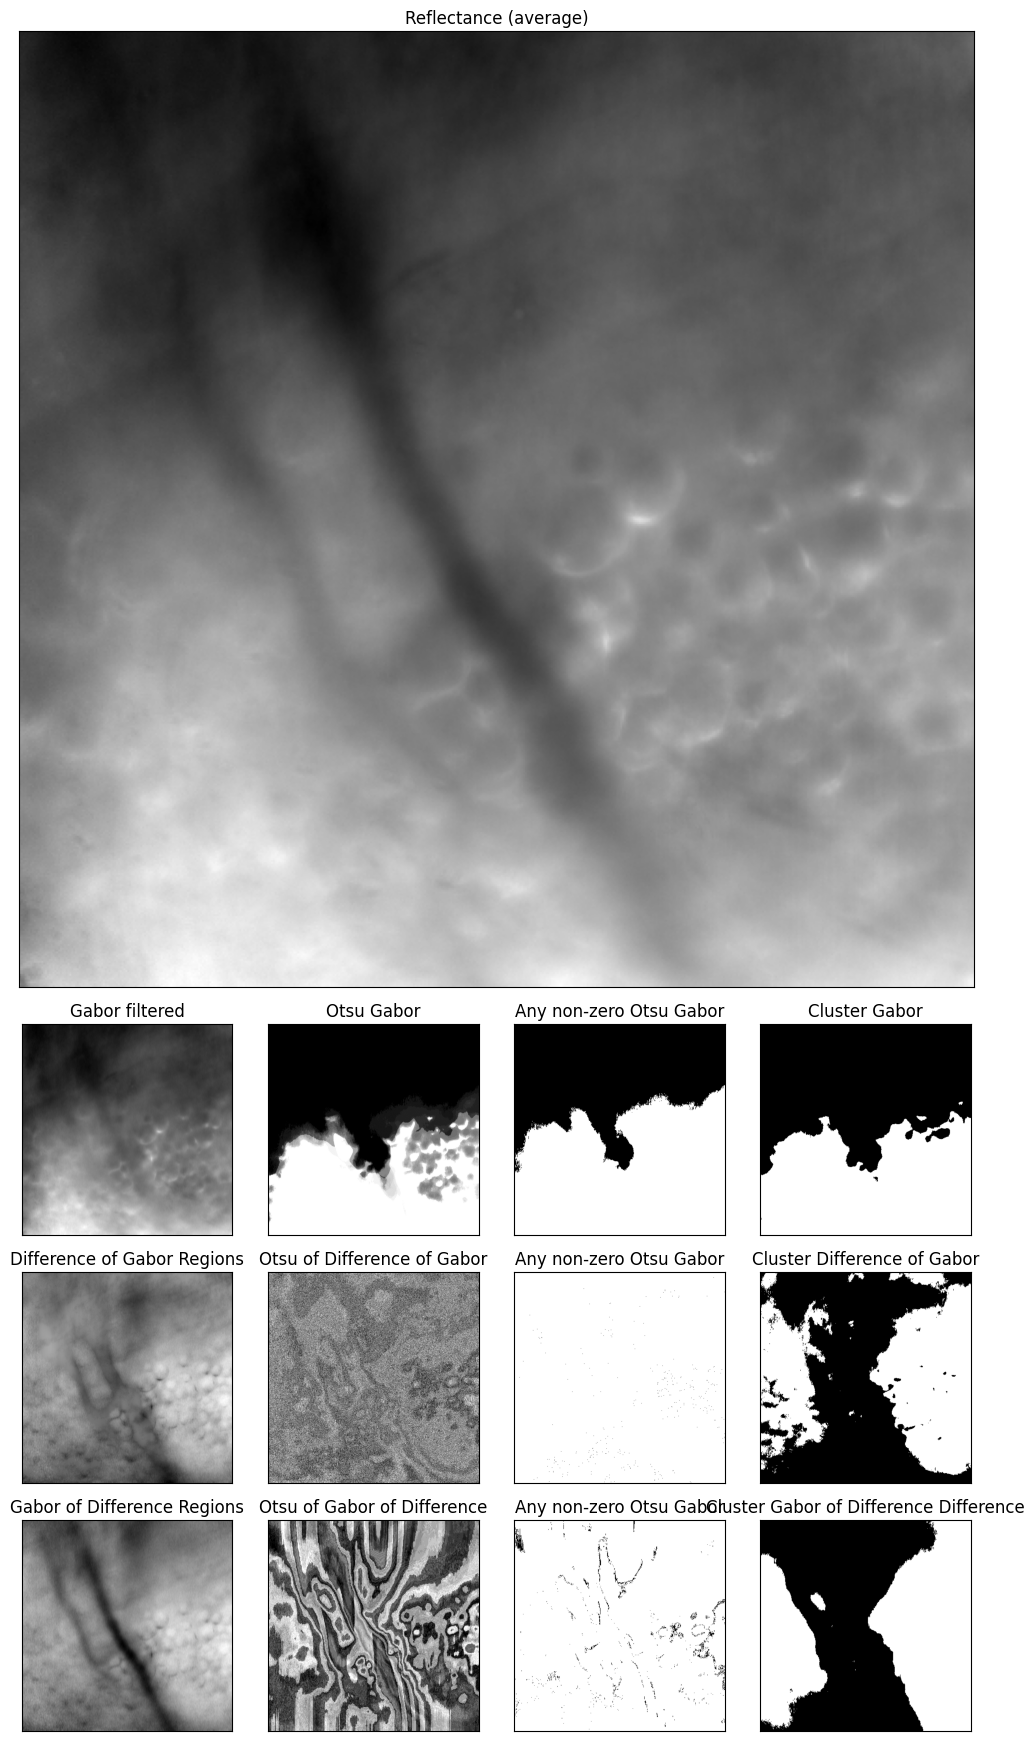

In [103]:
fig = plt.figure(figsize=(10, 20))
plt.set_cmap("gray")
gs = gridspec.GridSpec(ncols=4, nrows=8, figure=fig)

ax = fig.add_subplot(gs[0:4, 0:4])
ax.imshow(np.average(ref, axis=0))
ax.set_title("Reflectance (average)")

ax = fig.add_subplot(gs[4, 0])
ax.imshow(np.max(gabored, axis=0))
ax.set_title("Gabor filtered")
ax = fig.add_subplot(gs[4, 1])
ax.imshow(np.sum(otsu_gabored, axis=0))
ax.set_title("Otsu Gabor")
ax = fig.add_subplot(gs[4, 2])
ax.imshow(np.any(otsu_gabored, axis=0))
ax.set_title("Any non-zero Otsu Gabor")
ax = fig.add_subplot(gs[4, 3])
ax.imshow(cluster_gabored > 0)
ax.set_title("Cluster Gabor")

ax = fig.add_subplot(gs[5, 0])
ax.imshow(np.max(diff_gabored, axis=0))
ax.set_title("Difference of Gabor Regions")
ax = fig.add_subplot(gs[5, 1])
ax.imshow(np.sum(otsu_diff, axis=0))
ax.set_title("Otsu of Difference of Gabor")
ax = fig.add_subplot(gs[5, 2])
ax.imshow(np.any(otsu_diff, axis=0))
ax.set_title("Any non-zero Otsu Gabor")
ax = fig.add_subplot(gs[5, 3])
ax.imshow(cluster_diff > 0)
ax.set_title("Cluster Difference of Gabor")

ax = fig.add_subplot(gs[6, 0])
ax.imshow(np.max(gabored_diff, axis=0))
ax.set_title("Gabor of Difference Regions")
ax = fig.add_subplot(gs[6, 1])
ax.imshow(np.sum(otsu_gabored_diff, axis=0))
ax.set_title("Otsu of Gabor of Difference")
ax = fig.add_subplot(gs[6, 2])
ax.imshow(np.any(otsu_gabored_diff, axis=0))
ax.set_title("Any non-zero Otsu Gabor")
ax = fig.add_subplot(gs[6, 3])
ax.imshow(cluster_gabored_diff)
ax.set_title("Cluster Gabor of Difference Difference")

for ax in fig.get_axes():
    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()

##### Computing psuedo Hb Index to improve contrast

In [104]:
hb_index = (
    (hs[wavelengths == 630] - hs[wavelengths == 560])
    / (hs[wavelengths == 560] + hs[wavelengths == 630])
).squeeze()

freqs = np.geomspace(0.01, 1, 16)

kernel_bank = gabor_filter_bank(freqs)
gabored = apply_kernel_bank(hb_index, kernel_bank)
hb_index_cluster, _, _ = cluster_flow(gabored, ks)

0it [00:00, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

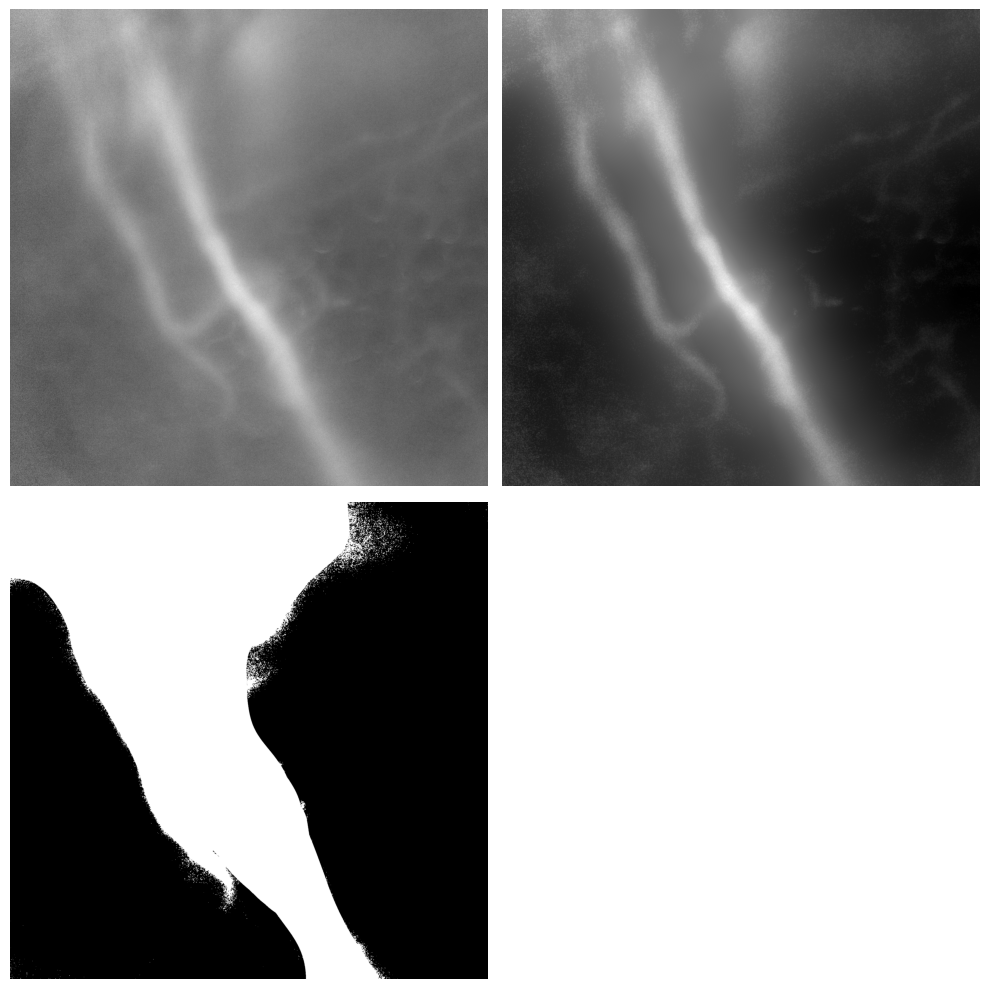

In [105]:
fig = plt.figure(figsize=(10, 10))
plt.set_cmap("gray")
gc = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax = fig.add_subplot(gc[0, 0])
im = ax.imshow(hb_index)
ax = fig.add_subplot(gc[0, 1])
ax.imshow(gabored)
ax = fig.add_subplot(gc[1, 0])
ax.imshow(hb_index_cluster == 0)
# ax = fig.add_subplot(gc[1, 1])
# ax.imshow(cluster_diff)

for ax in fig.get_axes():
    ax.axis("off")

plt.tight_layout()
plt.show()

  0%|          | 0/262144 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

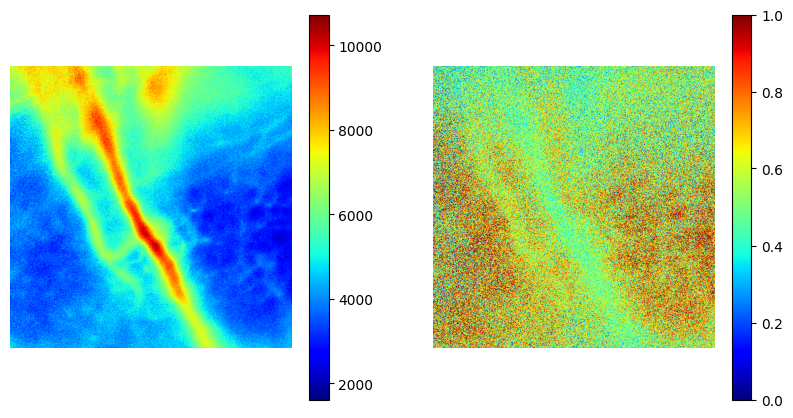

In [106]:
from photon_canon.contrib.bio import wl, eps

# Load extinction coeffs
selected = np.isin(wl, wavelengths)
eps = np.log(10) * eps[:, selected] / 64500

# Create design matrix
A = np.column_stack([eps.T, np.ones_like(wavelengths)])
c = np.zeros((A.shape[1], *ref.shape[1:]))
ref = spatial_bin(hs, 4)
for i, j in itertools.product(range(ref.shape[1]), range(ref.shape[2])):
    log_r = -np.log((ref[:, i, j] / mc_correction[:, i, j]))
    c[:, i, j], _, _, _ = np.linalg.lstsq(A, log_r, rcond=None)
thb = c[0] + c[1]
so2 = c[0] / thb
so2 = np.clip(so2, 0, 1)
plt.set_cmap("jet")
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.axis("off")
im = ax.imshow(thb)
fig.colorbar(im, ax=ax)
ax = fig.add_subplot(122)
ax.axis("off")
im = ax.imshow(so2)
fig.colorbar(im, ax=ax)
plt.show()

In [150]:
np.unravel_index(np.argmax(thb), thb.shape)

(np.int64(328), np.int64(265))

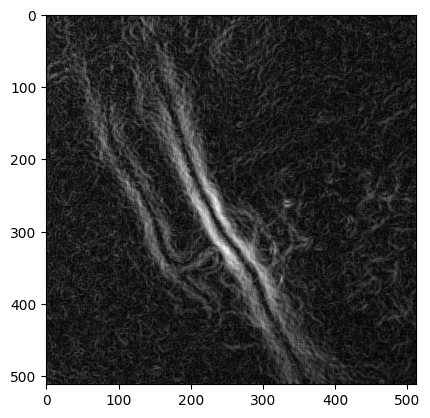

In [145]:
gradient = np.gradient(cv2.blur(thb, (5, 5)))
plt.imshow(np.sqrt(gradient[0] ** 2 + gradient[1] ** 2))

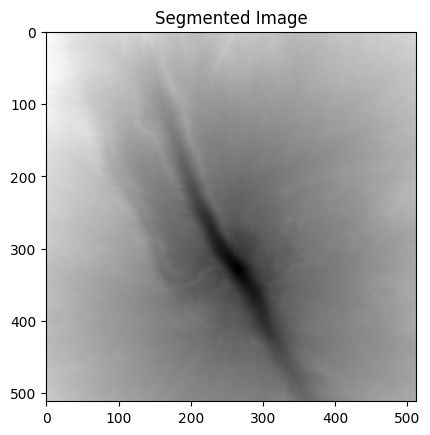

In [161]:
import numpy as np
import heapq


def segment_thb_dijkstra(thb, alpha=1):
    rows, cols = thb.shape
    gradient = np.gradient(cv2.blur(thb, (5, 5)))  # Smoothed gradient calculation
    weights = np.sqrt(
        gradient[0] ** 2 + gradient[1] ** 2
    )  # Gradient magnitude as weights
    weights /= weights.max()

    visited = np.zeros_like(thb, dtype=bool)
    distances = np.full_like(thb, np.inf)

    # Starting from the most "vascular" pixel (highest intensity)
    start_r, start_c = np.unravel_index(np.argmax(thb), thb.shape)
    distances[start_r, start_c] = 0
    pq = [(0, start_r, start_c)]  # Start from the most vascular pixel

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while pq:
        dist, r, c = heapq.heappop(pq)
        if visited[r, c]:
            continue
        visited[r, c] = True

        for dr, dc in directions:
            nr, nc = r + dr, c + dc

            if 0 <= nr < rows and 0 <= nc < cols:
                # Apply gradient scaling with alpha
                new_dist = dist + alpha * weights[nr, nc]
                if new_dist < distances[nr, nc]:
                    distances[nr, nc] = new_dist
                    heapq.heappush(pq, (new_dist, nr, nc))

    return distances


segmented_thb = segment_thb_dijkstra(thb)
plt.imshow(segmented_thb, cmap="gray")
plt.title("Segmented Image")
plt.show()

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

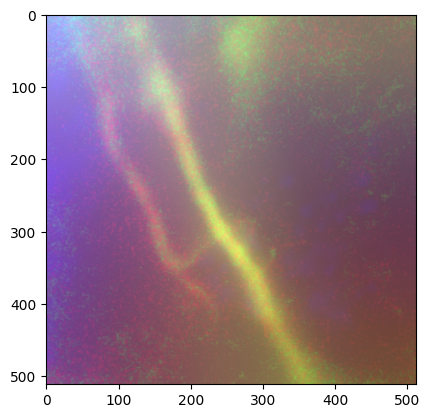

In [107]:
g = np.array([np.abs(apply_kernel_bank(C, kernel_bank)) for C in c])
g_color = (g / g.max(axis=(1, 2), keepdims=True)).transpose(1, 2, 0)
plt.imshow(g_color)
plt.show()

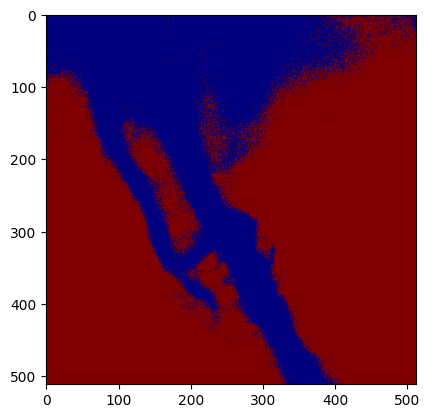

In [108]:
thb_cluster, _, _ = cluster_flow(thb, ks)
plt.imshow(thb_cluster)
plt.show()

#### Comparison of best masks

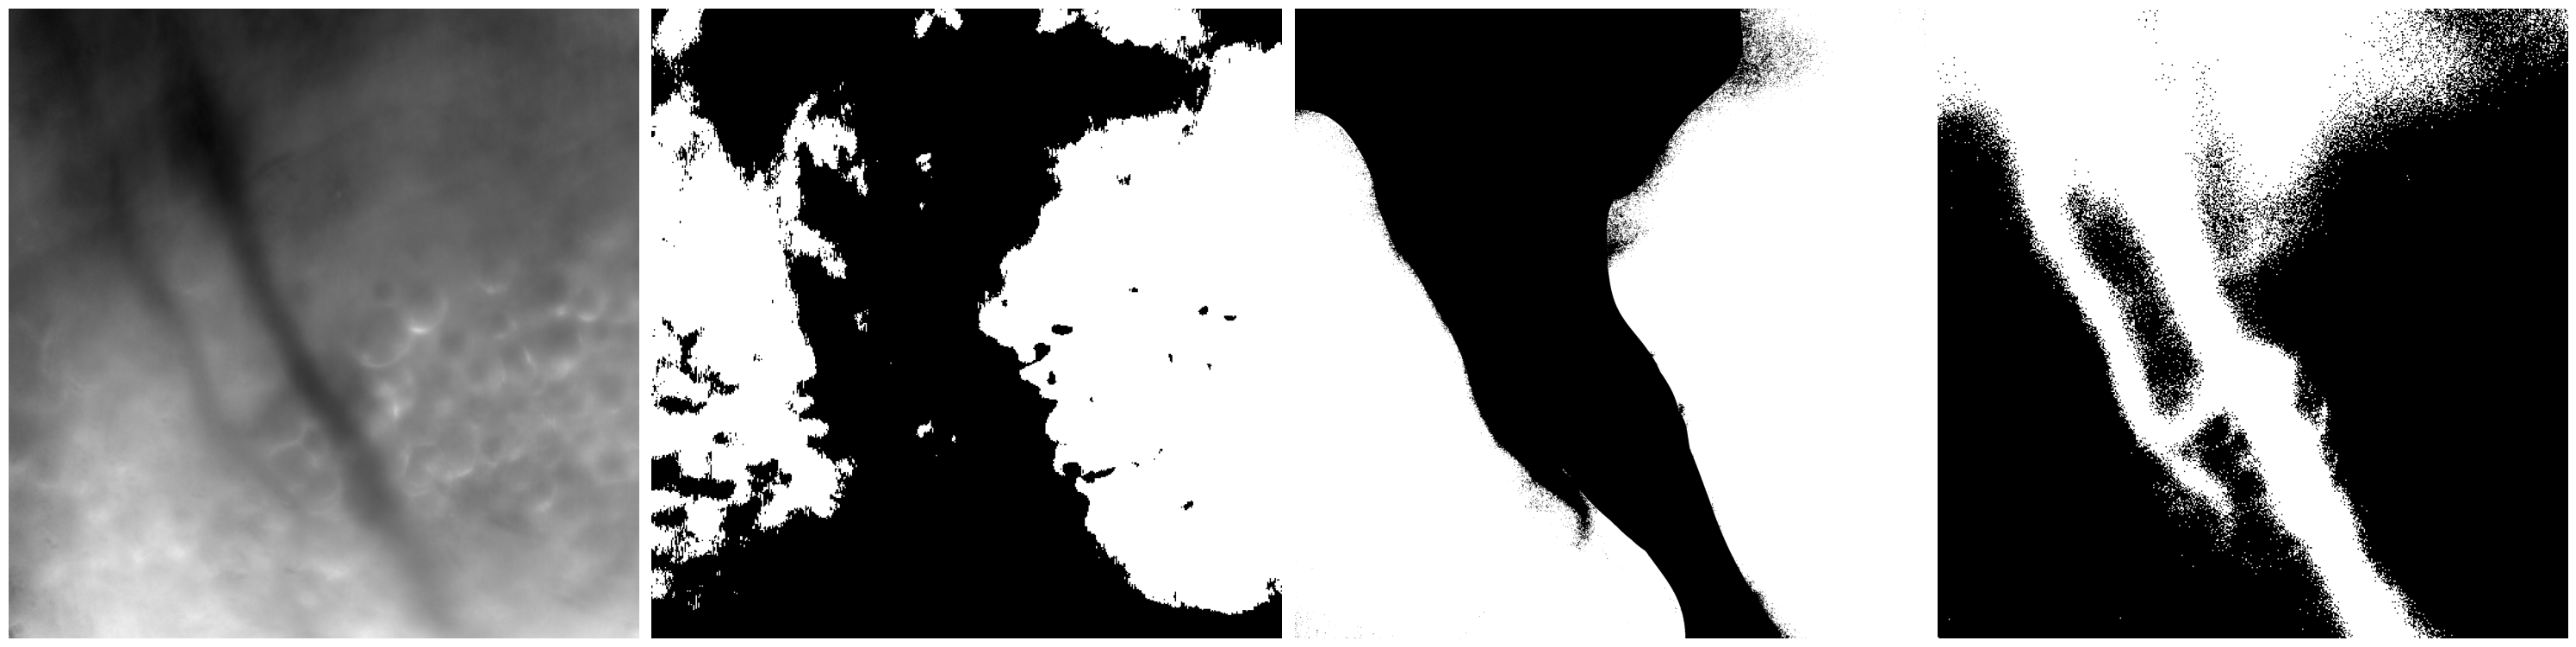

In [120]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10))
plt.set_cmap("gray")
ax[0].imshow(np.average(hs, axis=0))
ax[1].imshow(cluster_diff)
ax[2].imshow(hb_index_cluster)
ax[3].imshow(1 - thb_cluster)
for ax in fig.get_axes():
    ax.axis("off")
fig.tight_layout()
plt.show()

#### Perform morphological cleaning on masks

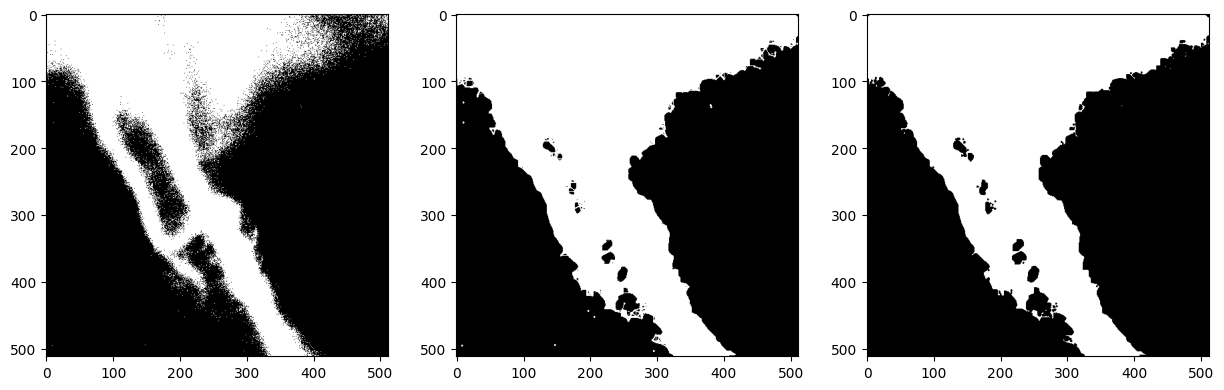

In [115]:
mask = 1 - thb_cluster > 0
fig = plt.figure(figsize=(15, 45))
plt.set_cmap("gray")
ax = fig.add_subplot(131)
ax.imshow(mask)

ksize = 3
strel = np.zeros((ksize, ksize), dtype=np.uint8)
strel[ksize // 2, :] = 1
strel[:, ksize // 2 :] = 1
dilated = cv2.dilate(mask.astype(np.uint8), strel)

ksize = 9
strel = np.zeros((ksize, ksize), dtype=np.uint8)
strel[ksize // 2, :] = 1
theta = np.arange(0, 180, 15)

stack = np.zeros((2 * len(theta),) + mask.shape)
for i, t in enumerate(theta):
    k = ndimage.rotate(strel, t, reshape=False)
    stack[i] = cv2.morphologyEx(
        dilated, cv2.MORPH_CLOSE, k, borderType=cv2.BORDER_CONSTANT, borderValue=0
    )
ax = fig.add_subplot(132)
ax.imshow(np.any(stack, axis=0))

ksize = 3
strel = np.zeros((ksize, ksize), dtype=np.uint8)
strel[ksize // 2, :] = 1
strel[:, ksize // 2 :] = 1
mask = cv2.erode(np.any(stack, axis=0).astype(np.uint8), strel)
ax = fig.add_subplot(133)
ax.imshow(mask)

plt.show()

#### Fit masked

In [116]:
# Example wavelengths and reflectance data (replace with your data)
mask = 1 - thb_cluster > 0
reflectance = hs / mc_correction
reflectance = np.array(
    [
        cv2.resize(reflectance[i], (512, 512), interpolation=cv2.INTER_CUBIC)
        for i in range(hs.shape[0])
    ]
)
reflectance[..., ~mask] = np.nan
wavelengths = np.array(metadata["Filter"])

# Initial guesses for the tissue properties
initial_guess = [1, 1, 1, 1]

# Fit the model
a, b, t, s = fit_all_from_monte_carlo(wavelengths, reflectance, initial_guess)

  0%|          | 0/262144 [00:00<?, ?it/s]

C:\Users\jdivers\AppData\Local\Temp\ipykernel_134276\2434338296.py:24: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(str(e))


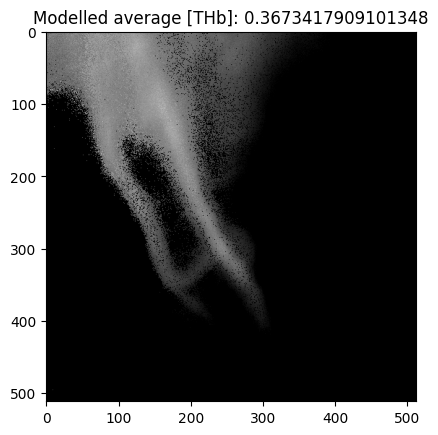

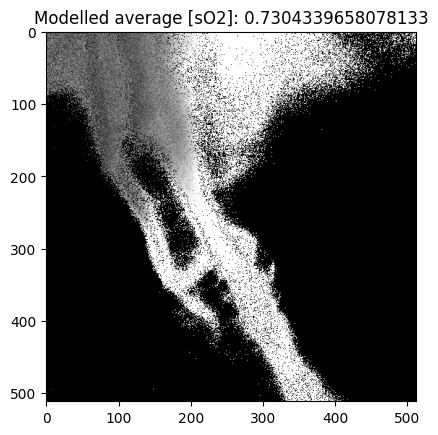

In [117]:
# Display the image
plt.imshow(t, "gray")
plt.title(f"Modelled average [THb]: {np.nanmean(t[mask])}")
plt.show()

# Display the image
plt.imshow(s, "gray")
plt.title(f"Modelled average [sO2]: {np.nanmean(s[mask])}")
plt.show()

In [118]:
R_modelled = np.zeros_like(ref)
for i, j in itertools.product(range(512), range(512)):
    R_modelled[:, i, j] = monte_carlo_model_from_hemoglobin(
        wavelengths, a[i, j], b[i, j], t[i, j], s[i, j]
    )

  0%|          | 0/262144 [00:00<?, ?it/s]

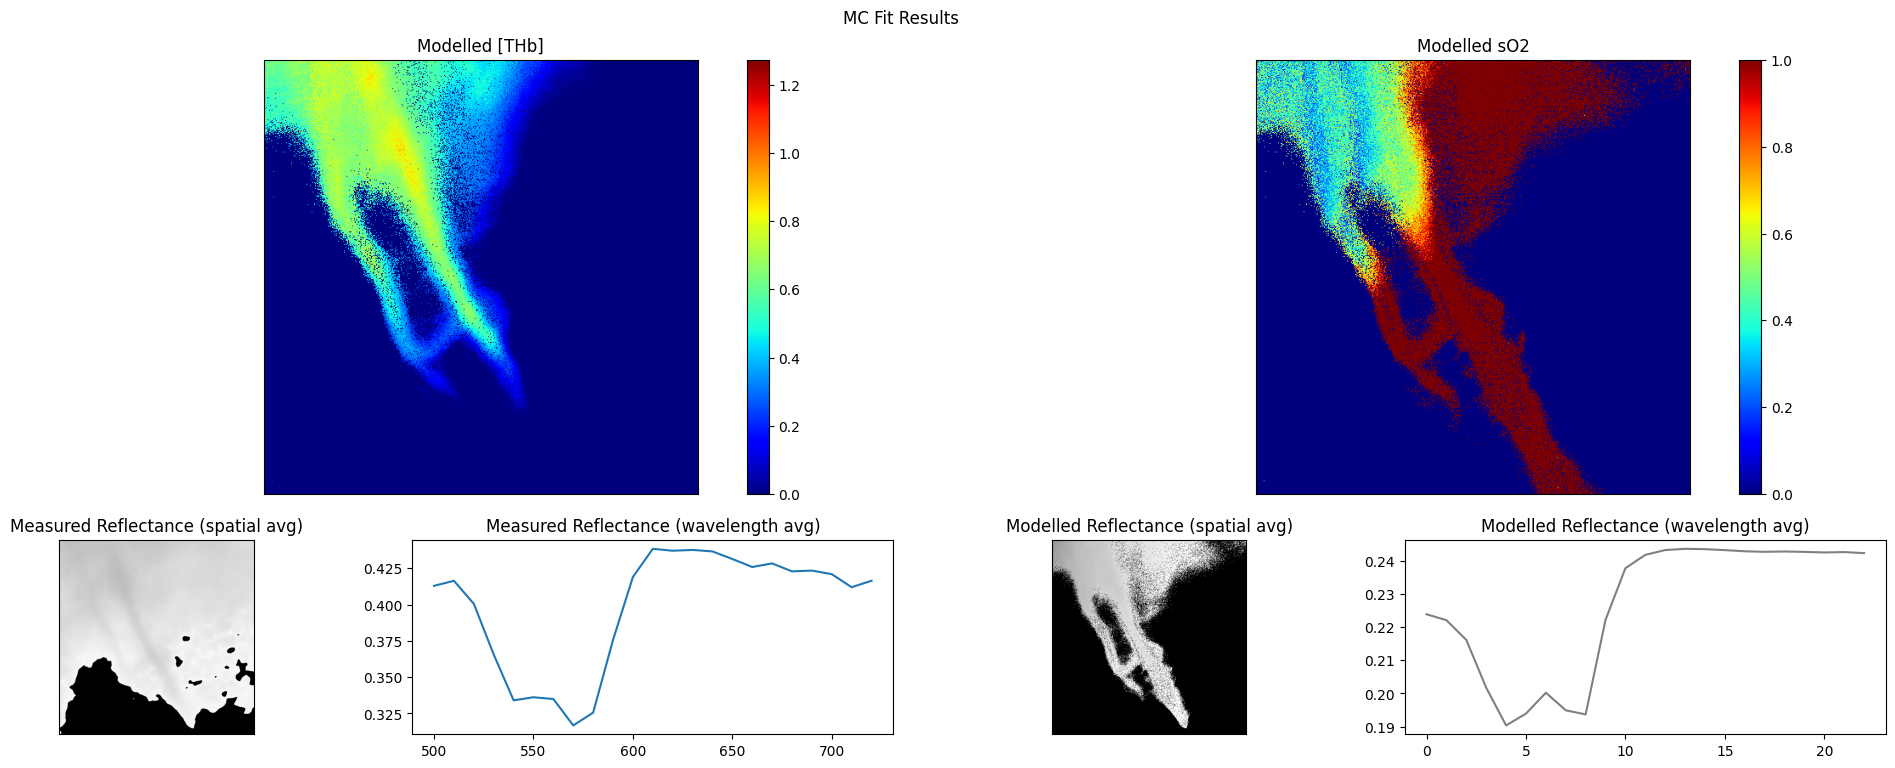

In [119]:
# Display the image
fig = plt.figure(figsize=(20, 10))
fig.suptitle("MC Fit Results")
gc = gridspec.GridSpec(4, 4)
ax = plt.subplot(gc[0:2, 0:2])
im = ax.imshow(t, "jet")
ax.set_title("Modelled [THb]")
fig.colorbar(im, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

# Display the image
ax = plt.subplot(gc[0:2, 2:4])
im = ax.imshow(s, "jet")
ax.set_title("Modelled sO2")
fig.colorbar(im, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

# Original image
ref = np.array(
    [
        cv2.resize(hs[i], (512, 512), interpolation=cv2.INTER_CUBIC)
        for i in range(hs.shape[0])
    ]
)
ax = plt.subplot(gc[2, 0])
ax.imshow(np.average(ref * cluster[np.newaxis, :, :], axis=0), "gray")
ax.set_title("Measured Reflectance (spatial avg)")
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gc[2, 1])
ax.plot(wavelengths, np.average(ref * cluster[np.newaxis, :, :], axis=(1, 2)))
ax.set_title("Measured Reflectance (wavelength avg)")

ax = plt.subplot(gc[2, 2])
ax.imshow(np.average(R_modelled * cluster[np.newaxis, :, :], axis=0), "gray")
ax.set_title("Modelled Reflectance (spatial avg)")
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gc[2, 3])
ax.plot(np.average(R_modelled * cluster[np.newaxis, :, :], axis=(1, 2)), "gray")
ax.set_title("Modelled Reflectance (wavelength avg)")

fig.tight_layout()
plt.show()

# Breakdown of flow of data
1) Load and normalize references
   - Background
   - Reflectance standard
2) Load known scatterer and calculate model correction factor
** For all samples **
    1) Load sample, normalize, and downsample to match MPM
        - To integration time
        - To standard and background
   2) Perform naive least squared fit on -log(R) to index Hb (NOTE: Consider down sampling here, then up sampling after clustering to get a smoother mask)
   3) Perform K-Means clustering on THb index to create mask (NOTE: If upsampling here, then be sure to re-evaluate mask = mask > 0 since edges will be interpolated between True and False)
   4) Apply LUT correction to image
   5) Fit full model

## Let's now run through step 2 of that with a new image

### 2A: Load & normalize

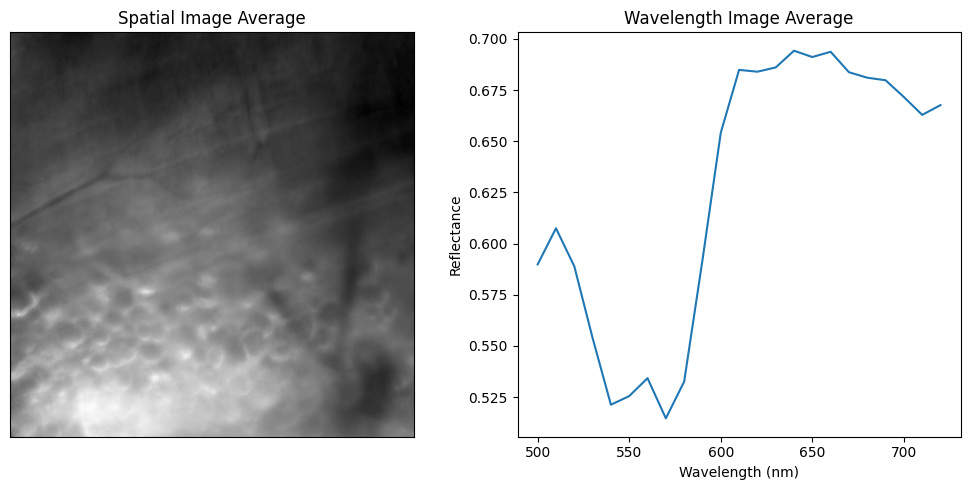

In [393]:
img_dir = r"E:\new df\03312025\1675NT\21\fov4\cycle1"
metadata = read_imaging_metadata(glob.glob(os.path.join(img_dir, "*metadata.json"))[0])
wavelengths = metadata["Wavelength"]
hs = read_hyperstack(img_dir)
hs = normalize_integration_time(hs, metadata["ExpTime"])
hs = normalize_to_standard(hs, standard, bg)
hs = spatial_bin(hs, bin_factor=4)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.average(hs, axis=0), "gray")
ax[0].set_title("Spatial Image Average")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].plot(wavelengths, np.average(hs, axis=(1, 2)))
ax[1].set_title("Wavelength Image Average")
ax[1].set(xlabel="Wavelength (nm)", ylabel="Reflectance")
plt.tight_layout()
plt.show()

### 2B: Naive Fit for Hb Indexing

  0%|          | 0/262144 [00:00<?, ?it/s]

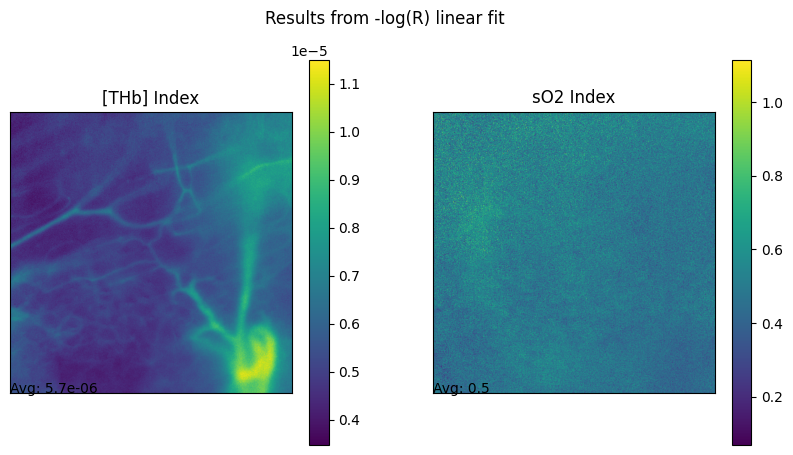

In [447]:
# Load extinction coeffs
ref = np.clip(hs, 1e-6, 1)
log_ref = -np.log(ref)
selected = np.isin(wl, wavelengths)
Hb = dhb[selected]
HbO2 = hbo2[selected]

# Create design matrix
A = np.stack([Hb, HbO2, np.ones_like(wavelengths)], axis=-1)
c = np.zeros((A.shape[1], *log_ref.shape[1:]))
for i, j in itertools.product(range(log_ref.shape[1]), range(log_ref.shape[2])):
    r = log_ref[:, i, j] / mc_correction[:, i, j]
    c[:, i, j], _, _, _ = np.linalg.lstsq(A, r, rcond=None)
thb = c[0] + c[1]
so2 = c[1] / thb
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Results from -log(R) linear fit")
im = ax[0].imshow(thb)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("[THb] Index")
ax[0].text(0, ax[0].get_ylim()[0], f"Avg: {np.average(thb):0.2g}")
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(so2)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("sO2 Index")
ax[1].text(0, ax[1].get_ylim()[0], f"Avg: {np.average(so2):0.2g}")
fig.colorbar(im, ax=ax[1])
plt.show()

### 2C: Segmentation through Clustering on [THb]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

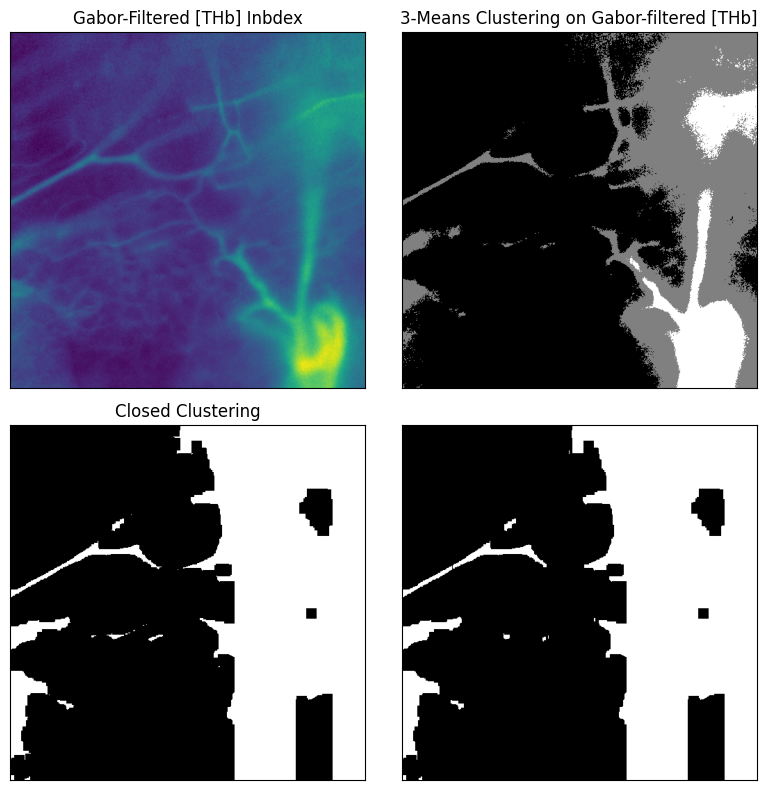

In [599]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

kernel_bank = gabor_filter_bank(np.geomspace(0.5, 1, 100))
gabored = apply_kernel_bank(thb, kernel_bank)
ax[0, 0].imshow(gabored)
ax[0, 0].set_title("Gabor-Filtered [THb] Inbdex")

clusters, scores = try_n_clusters(gabored, ks)
cluster, elbow = find_elbow_clusters(clusters, scores)
cluster = slice_clusters(gabored, cluster, slice(elbow, None))
ax[0, 1].imshow(sort_clusters(thb, clusters[elbow]), "gray")
ax[0, 1].set_title(f"{ks[elbow]}-Means Clustering on Gabor-filtered [THb]")

# TODO: Try closing with a filter bank of 1D kernels
kernel = np.ones((15, 15), np.uint8)
close_cluster = cv2.morphologyEx(cluster.astype(float), cv2.MORPH_CLOSE, kernel)
ax[1, 0].imshow(close_cluster, "gray")
ax[1, 0].set_title("Closed Clustering")

kernel = np.zeros((5, 5), np.uint8)
kernel[:, 2] = 1

mask = cv2.morphologyEx(close_cluster, cv2.MORPH_OPEN, kernel)
ax[1, 1].imshow(mask, "gray")

plt.tight_layout()
plt.show()

C:\Users\jdivers\AppData\Local\Temp\ipykernel_30808\1746215071.py:10: RuntimeWarning: invalid value encountered in cast
  closed = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, k).astype(np.uint8)


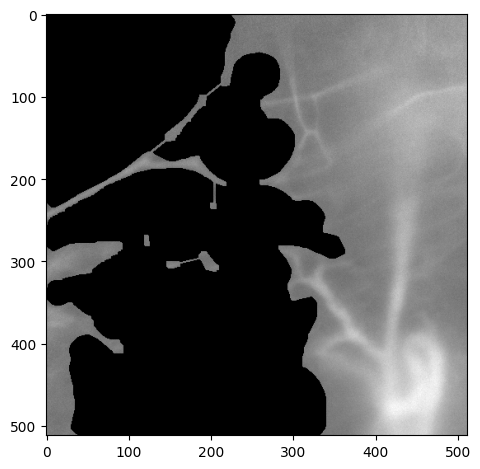

In [536]:
import scipy

ksize = 25
kernel = np.zeros((ksize, ksize), np.uint8)
kernel[:, ksize // 2] = 1

mask = np.zeros((15,) + close_cluster.shape, np.uint8)
for i, t in enumerate(np.linspace(0, np.pi, 15)):
    k = scipy.ndimage.rotate(kernel, angle=np.degrees(t))
    cleaned = cv2.morphologyEx(close_cluster, cv2.MORPH_OPEN, np.ones((5, 5)))
    closed = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, k).astype(np.uint8)
    mask[i] = closed
plt.imshow(np.max(mask, axis=0) * thb, "gray")

plt.tight_layout()
plt.show()

### Questions
1) Are you sufficiently satisfied with these images?
    - Will you want me to wait to defend until after the next round of surgeries can be incorporated into the dataset?
    - Would you like me to integrate a more robust system design or attempt integration on Muldoon's MPM?
2) Any ideas how to capture the vasculature more reliably?
    - Gabor filter tuning?
    - Open/closing?

# Next steps
- [x] Get a full vascular map:
    1) Upsample downsampled fit
    2) Threshold map
       - Consider masking techniques: matched, gabor, djikstra
    3) Re-perform fit for full image size only at masked pixels
    4) Calculate loss
    - What if we do some open/closing on the mask?
- [ ] Validate model/pipeline with food coloring images
- [ ] Build OOP for HSDFM images
    1) Image class with init by path and methods:
        - normalize/standardize (by integration time and standard image)
        - filtering/segmentation options (matched, gabor, otsu, clustering)
    - Build pipeline to interact with image object
        - "list" of task handles
        -
- [ ] Build out MPM processing
- [ ] Build registration procedure
- [ ] Create distance metric
    1) Calculate distance to musculature image (distance transform + add the mask back so all curvature gets the same score)
- [ ] Model Krogh Cylinders
- [ ] Compare extracted properties across oxygenations (ORR, sO$_2$, [THb], $\frac{\alpha_1}{\alpha_2}$, $\tau_M$)
- [ ] Compared engineered features across oxygenations (DTV, Cylinder Metrics)
- [ ] PCA/t-SNE for segmentation?
